### Вступление

**Название проекта**: Анализ бизнес показателей компании Procrastinate Pro+.   
    
**Описание проекта**: Несмотря на огромные вложения компании Procrastinate Pro+ в рекламу, последние несколько месяцев компания терпит убытки.
    
**Цель проекта**: Разобраться в причинах убытков компании и помочь компании выйти в плюс. 

**Описание данных**:

*Структура visits_info_short.csv:*

- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

*Структура orders_info_short.csv:*

- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

*Структура costs_info_short.csv:*

- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

### Загрузка и подготовка данных

In [1]:
#Добавим необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Загружаем данные
visits = pd.read_csv(r'D:\Аналитика\Аналитик данных\Dataset\visits_info_short.csv')
orders = pd.read_csv(r'D:\Аналитика\Аналитик данных\Dataset\orders_info_short.csv')
costs = pd.read_csv(r'D:\Аналитика\Аналитик данных\Dataset\costs_info_short.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#Выполняем предобработку данных
visits.info()
print(visits)

orders.info()
print(orders)

costs.info()
print(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
             User Id         Region   Device         Channel  \
0       981449118918  United States   iPhone         organic   
1       278965908054  United States   iPhone         organic   
2       590706206550  United States      Mac         organic   
3       326433527971  United States  Android          TipTop   
4       349773784594  United States      Mac         organic   
...              ...            ...      ...             ...   
309896  329994900775             UK    

### Предобработка данных

In [4]:
#Меняем типы данных
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   User Id        309901 non-null  int64         
 1   Region         309901 non-null  object        
 2   Device         309901 non-null  object        
 3   Channel        309901 non-null  object        
 4   Session Start  309901 non-null  datetime64[ns]
 5   Session End    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   User Id   40212 non-null  int64         
 1   Event Dt  40212 non-null  datetime64[ns]
 2   Revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

In [5]:
#Изучаем пропущенные данные в столбцах
display(visits.isna().sum())
display(orders.isna().sum())
display(costs.isna().sum())

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

User Id     0
Event Dt    0
Revenue     0
dtype: int64

dt         0
Channel    0
costs      0
dtype: int64

In [6]:
#Проверяем дубликаты
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


In [7]:
#Названия столбцов некорректно записаны, проверим и в случае необходимости поправим.
visits.columns

Index(['User Id', 'Region', 'Device', 'Channel', 'Session Start',
       'Session End'],
      dtype='object')

In [8]:
costs.columns

Index(['dt', 'Channel', 'costs'], dtype='object')

In [9]:
orders.columns

Index(['User Id', 'Event Dt', 'Revenue'], dtype='object')

In [10]:
#Необходимо привести названия столбцов к нижнему регистру и заменить пробелы на "_"
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start','session_end']
costs.columns = ['dt', 'channel', 'costs']
orders.columns = ['user_id', 'event_dt', 'revenue']  

In [11]:
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [12]:
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [13]:
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

В ходе предобработки данных были внесены следующие поправки: 
 1. Названия столбцов приведены к общему формату. 
 2. Была произведена проверка на дубликаты и пропуски 
 3. Измены типы данных в столбцах. В целом критичных аномалий не обнаружено.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

In [14]:
#Задаём функции для расчёта и анализа LTV, ROI, удержания и конверсии
#Создадим пользовательские профили
def get_profiles(sessions, orders, costs, dimensions=[]):
    user_prof = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first', 'channel': 'first', 'device': 'first','region': 'first'})
        .rename(columns={'session_start': 'first_start'})
        .reset_index()
    )
    user_prof['dt'] = user_prof['first_start'].dt.date
    user_prof['month'] = user_prof['first_start'].astype('datetime64[M]')
    user_prof['payer'] = user_prof['user_id'].isin(orders['user_id'].unique())
    new_users = (user_prof.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'unique_users'}).reset_index())
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    user_prof = user_prof.merge(costs[['dt', 'channel', 'acquisition_cost']], on=['dt', 'channel'], how='left',)
    user_prof['acquisition_cost'] = user_prof['acquisition_cost'].fillna(0)    
    return user_prof

In [15]:
user_prof = get_profiles(visits, orders, costs)
print(user_prof)

             user_id         first_start       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt         

In [16]:
#Рассчитываем коэффициент удержания
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_start']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):   
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')    
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) 
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                    
        result = result[['cohort_size'] + list(range(horizon_days))]                                            
        result['cohort_size'] = cohort_sizes                                                                    
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    return result_raw, result_grouped, result_in_time

In [17]:
#Для проверки вычислим удержание за 20 июля с горизонтом 12
retention_raw, retention, retention_history = get_retention(user_prof, visits, datetime(2019, 7, 20).date(), 12)
retention

cohort_size    0         1         2         3         4         5  \
payer                                                                       
False        54885  1.0  0.176515  0.086763  0.052328  0.034800  0.024269   
True          3283  1.0  0.416387  0.324398  0.267438  0.230277  0.216875   

              6         7         8         9        10        11  
payer                                                              
False  0.017874  0.013938  0.011861  0.009365  0.007689  0.006541  
True   0.197990  0.181541  0.171489  0.155650  0.151386  0.152909

In [18]:
#Функция для расчета конверсии
def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt']).groupby('user_id').agg({'event_dt': 'first'}).reset_index())
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_start']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions: 
        dimensions = []
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    return result_raw, result_grouped, result_in_time

In [19]:
#Для проверки вычислим конверсию за 20 июля с горизонтом 12
conversion_raw, conversion, conversion_history = get_conversion(user_prof, orders, datetime(2019, 7, 20).date(), 12)
conversion

cohort_size       0.0       1.0       2.0       3.0       4.0  \
cohort                                                                     
All users        58168  0.037993  0.043615  0.046503  0.048411  0.049959   

               5.0       6.0       7.0      8.0       9.0      10.0      11.0  
cohort                                                                         
All users  0.05075  0.051523  0.052417  0.05295  0.053483  0.053758  0.054068

In [20]:
#Функция для расчета (LTV)
def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False,):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left',)
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_start']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days)
    return result_raw, result_grouped, result_in_time

In [21]:
#Для проверки вычислим LTV за 20 июля с горизонтом 12
ltv_raw, ltv, ltv_history = get_ltv(user_prof, orders, datetime(2019, 7, 20).date(), 12)
ltv

cohort_size       0.0       1.0       2.0       3.0     4.0  \
cohort                                                                   
All users        58168  0.221551  0.288904  0.341155  0.385807  0.4238   

                5.0       6.0       7.0      8.0       9.0      10.0      11.0  
cohort                                                                          
All users  0.455851  0.487633  0.516819  0.54479  0.570735  0.593796  0.616911

In [22]:
#Строим функции для построения графиков
#Для сглаживания данных
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [23]:
#Для Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))    
    plt.tight_layout()
    plt.show()

In [24]:
#Для Конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

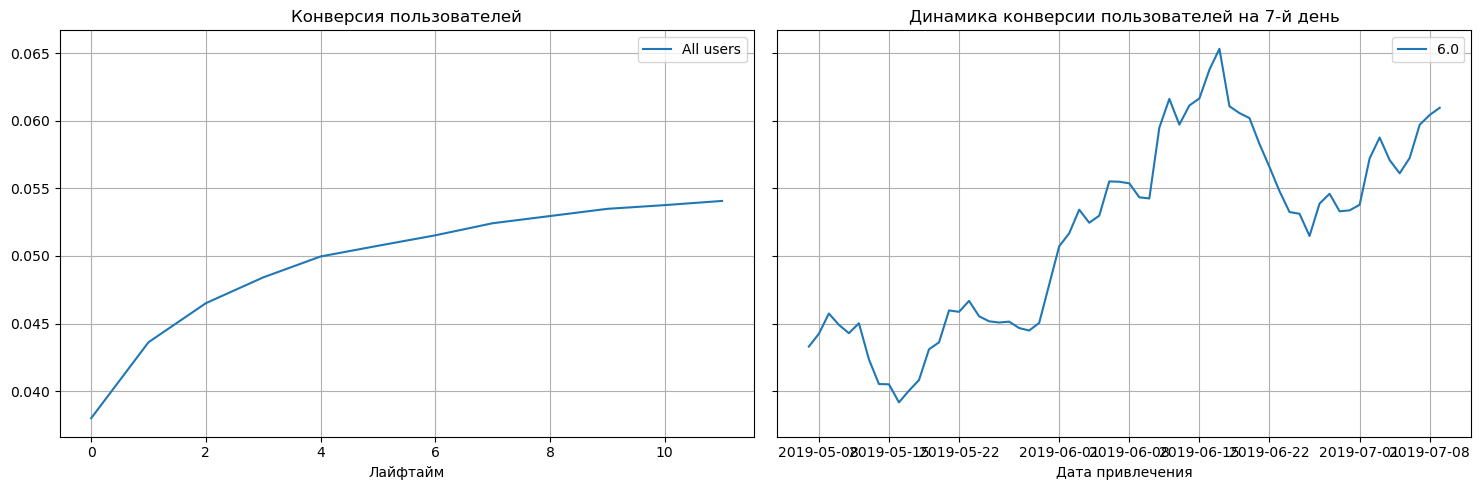

In [25]:
plot_conversion(conversion, conversion_history, 7) 

In [26]:
#Функция для LTV и ROI
def get_ltv_roi(profiles,purchases,observation_date,horizon_days,dimensions=[],ignore_horizon=False,):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_start']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (cac.groupby(dims).agg({'acquisition_cost': 'mean'}).rename(columns={'acquisition_cost': 'cac'}))
        roi = result.div(cac['cac'], axis=0)
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return (result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time,)

In [27]:
#Для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 20))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    ax3 = plt.subplot(3, 2, 3)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    ax4 = plt.subplot(3, 2, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    ax5 = plt.subplot(3, 2, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show()

In [28]:
ltv_raw, ltv_grouped, ltv_history,  roi_grouped, roi_history = get_ltv_roi(user_prof, orders, datetime(2019, 7, 20).date(), 12)
ltv

cohort_size       0.0       1.0       2.0       3.0     4.0  \
cohort                                                                   
All users        58168  0.221551  0.288904  0.341155  0.385807  0.4238   

                5.0       6.0       7.0      8.0       9.0      10.0      11.0  
cohort                                                                          
All users  0.455851  0.487633  0.516819  0.54479  0.570735  0.593796  0.616911

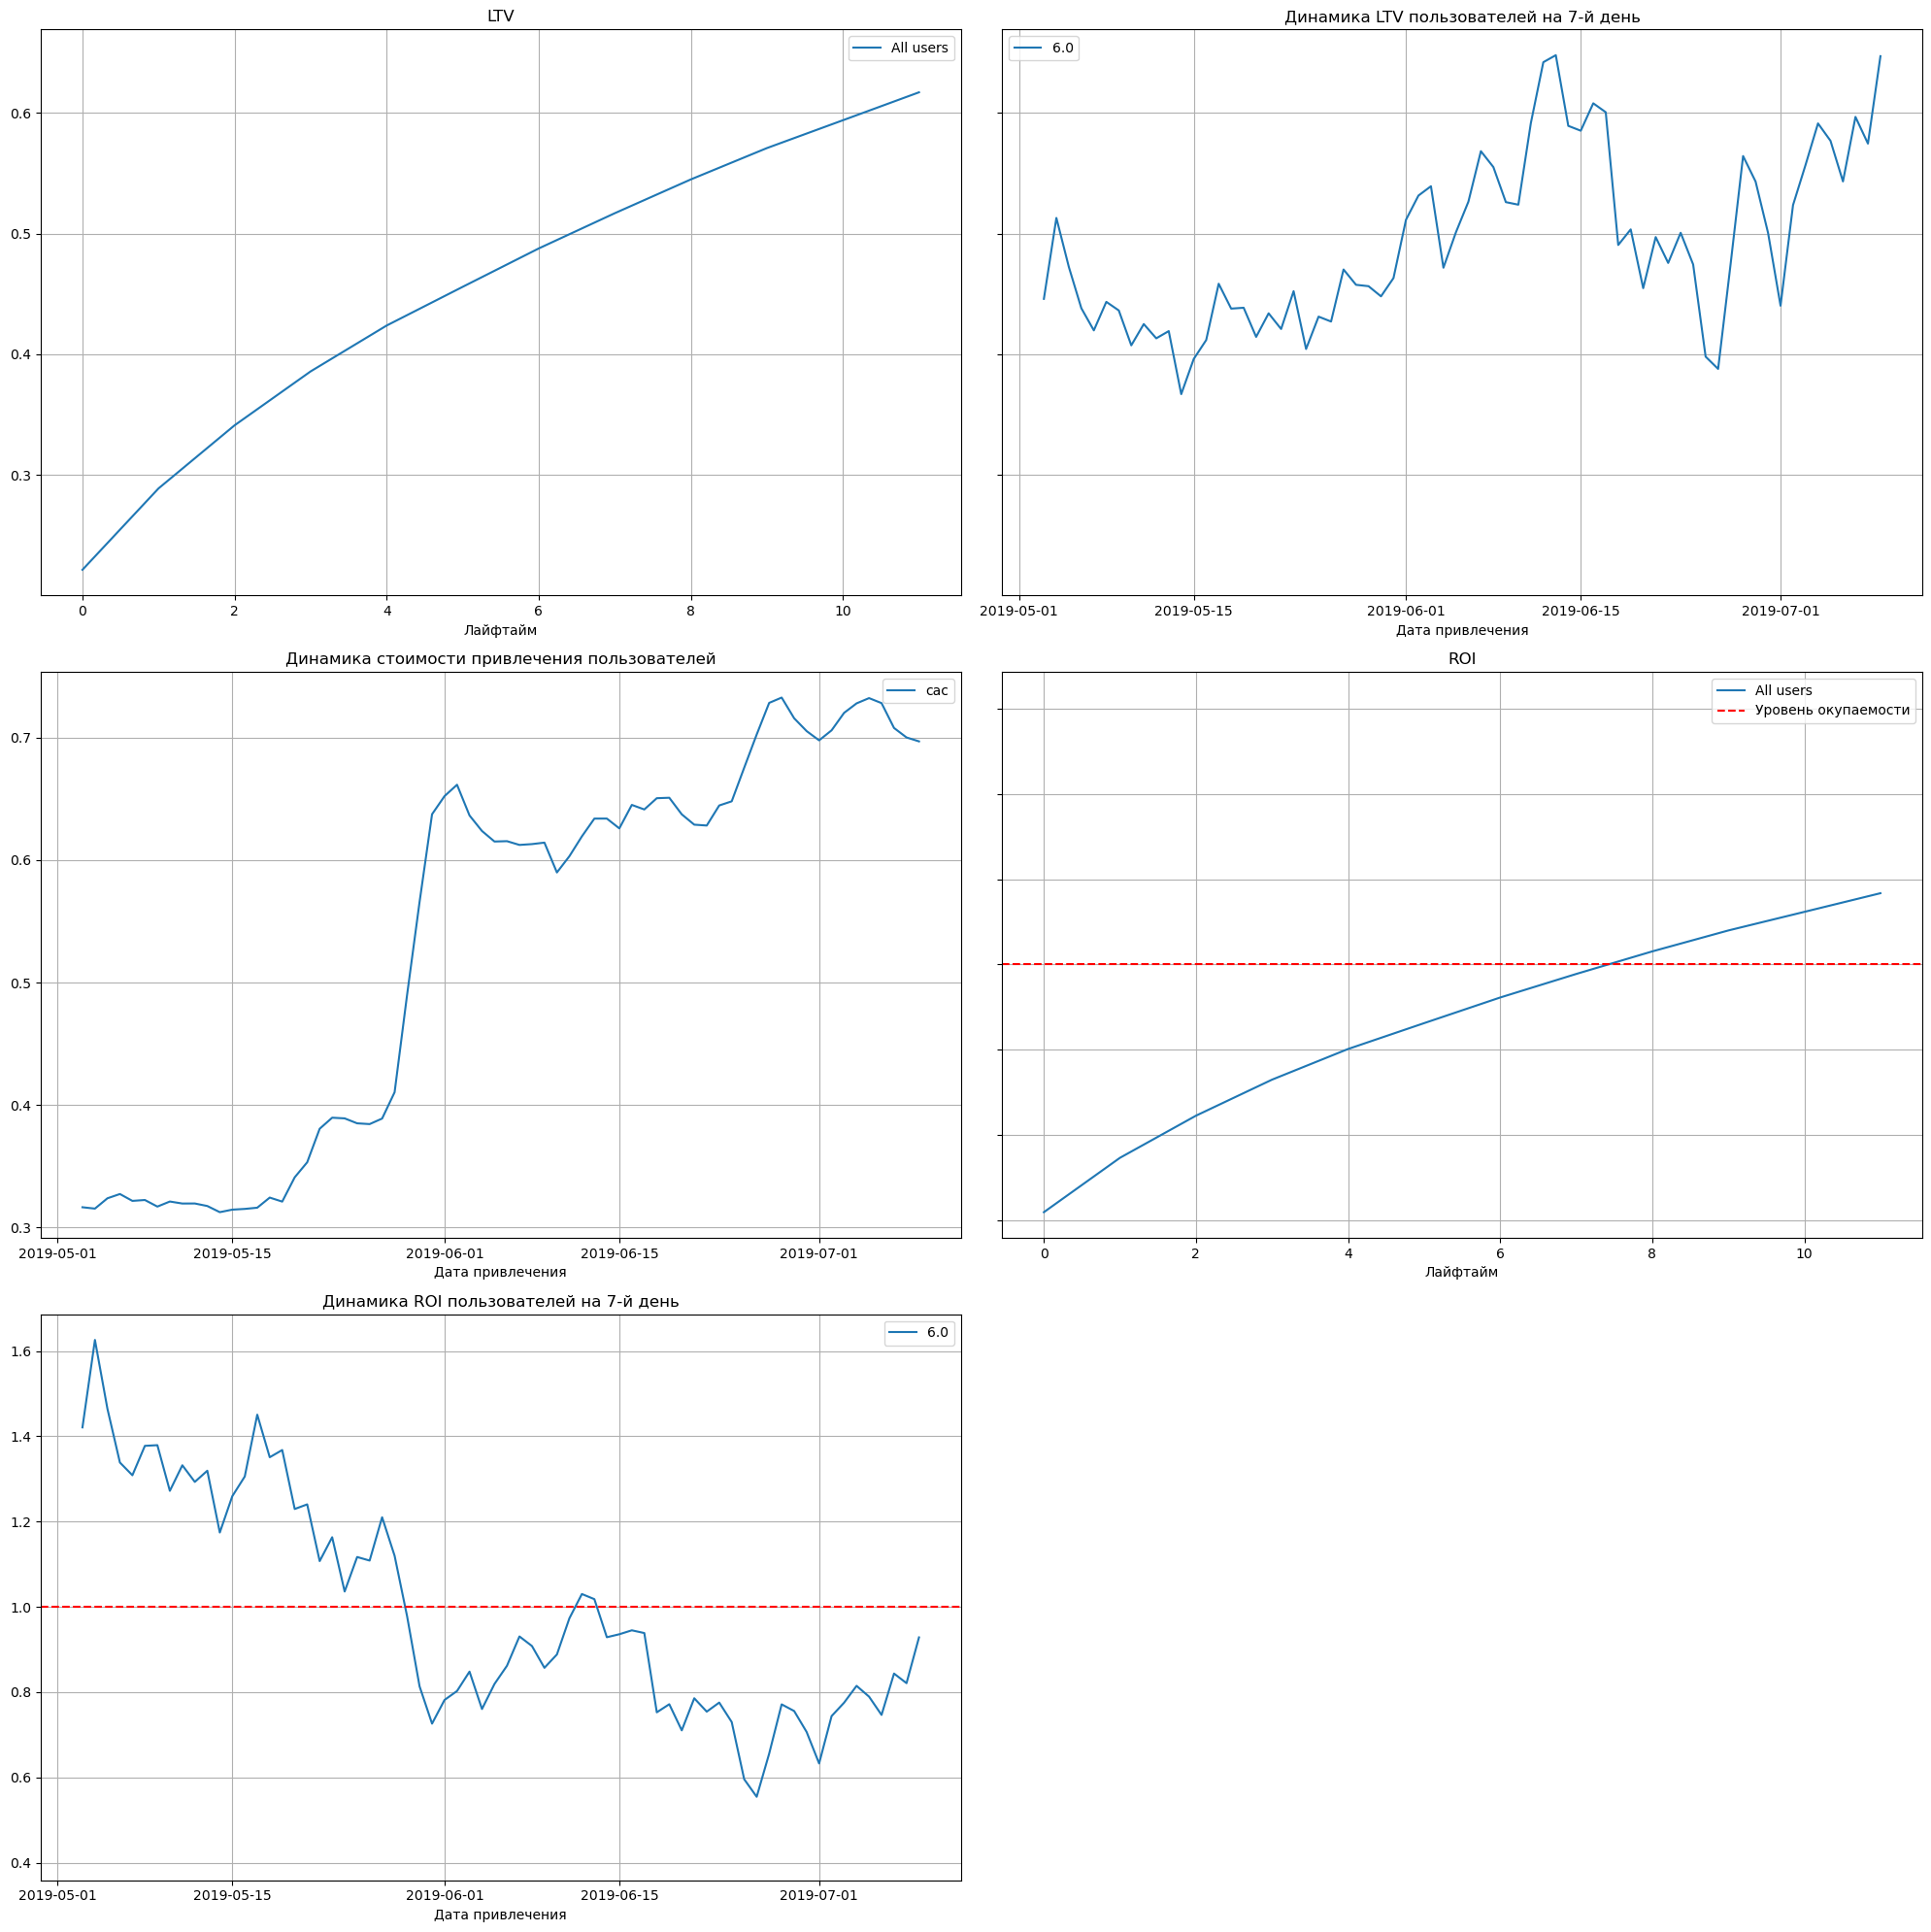

In [29]:
plot_ltv_roi(ltv, ltv_history, roi_grouped, roi_history, 7, window=3)

### Исследовательский анализ данных

In [30]:
#Составим профиль пользователей, определим минимальную и максимальную дату привлечения.
profiles = get_profiles(visits, orders, costs)
display(profiles)

user_id         first_start       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt               month  payer  acquisition_cost  
0       2019-05-07 2019-05-07 20:58:57   True          1.088172  
1       2019-07-09 2019-07-09 12:46:07  False          1.107237  
2       2019-10-01 2019-10-01 09:58:33  False          0.000000  
3       2019-08-22 2019-08-22 21:35:48  False          0.988235  
4       2019-10-02 2019-10-02 00:07:44  False          0.230769  
...            ...                 ...    ...               ...  
150003  2019-09-28 2019-09-28 08:33:02  False          3.500000  
150004  2019-10-21 2019-10-21 00:35:17  False          0.000000  
150005  2019-07-23 2019-07-23 02:57:06  False          2.600000  
150006  2019-09-28 2019-09-28 21:28:09  False          0.205714  
150007  2019-10-18 2019-10-18 19:57:25  False          0.000000  

[150008 rows x 9 columns]

In [31]:
#Определим минимальную и максимальную дату привлечения
n = profiles['dt'].max()
min = profiles['dt'].min()
max = n
print(min)
print(max)

2019-05-01
2019-10-27


Минимальная дата привлечения: 2019-05-01 Максимальная дата привлечения: 2019-10-27

In [32]:
#Посмотрим профили пользователей в разбивке по "channel", "device", "region".
chan = profiles.groupby('channel').agg({'user_id': 'count'})
chan['all'] = chan['user_id'].sum()
chan['proc'] = (chan['user_id'] / chan['all'] * 100).round(2).astype(str) + '%'
chan

user_id     all    proc
channel                                    
AdNonSense             3880  150008   2.59%
FaceBoom              29144  150008  19.43%
LeapBob                8553  150008    5.7%
MediaTornado           4364  150008   2.91%
OppleCreativeMedia     8605  150008   5.74%
RocketSuperAds         4448  150008   2.97%
TipTop                19561  150008  13.04%
WahooNetBanner         8553  150008    5.7%
YRabbit                4312  150008   2.87%
lambdaMediaAds         2149  150008   1.43%
organic               56439  150008  37.62%

In [33]:
dev = profiles.groupby('device').agg({'user_id': 'count'})
dev['proc'] = (dev['user_id'] / dev['user_id'].sum() * 100).round(2).astype(str) + '%'
dev

user_id    proc
device                  
Android    35032  23.35%
Mac        30042  20.03%
PC         30455   20.3%
iPhone     54479  36.32%

In [34]:
reg = profiles.groupby('region').agg({'user_id': 'count'})
reg['proc'] = (reg['user_id'] / reg['user_id'].sum() * 100).round(2).astype(str) + '%'
reg

user_id    proc
region                        
France           17450  11.63%
Germany          14981   9.99%
UK               17575  11.72%
United States   100002  66.66%

Минимальная дата привлечения 2019-05-01, максимальная 2019-10-14, с учетом, что период окупаемости две недели. Так же видно, что преимущественно пользователи из United States. Среди channel FaceBoom, а среди device iPhone.

In [35]:
#Выясняем из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих.
regg = profiles.groupby('region').agg({'user_id': 'count'})
regg['proc'] = (regg['user_id'] / regg['user_id'].sum() * 100).round(2).astype(str) + '%'
regg['payer'] = profiles.query('payer == True').groupby('region')['user_id'].count()
regg['proc_payer'] = (regg['payer'] / regg['user_id'] * 100).round(2).astype(str) + '%'
regg

user_id    proc  payer proc_payer
region                                          
France           17450  11.63%    663       3.8%
Germany          14981   9.99%    616      4.11%
UK               17575  11.72%    700      3.98%
United States   100002  66.66%   6902       6.9%

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


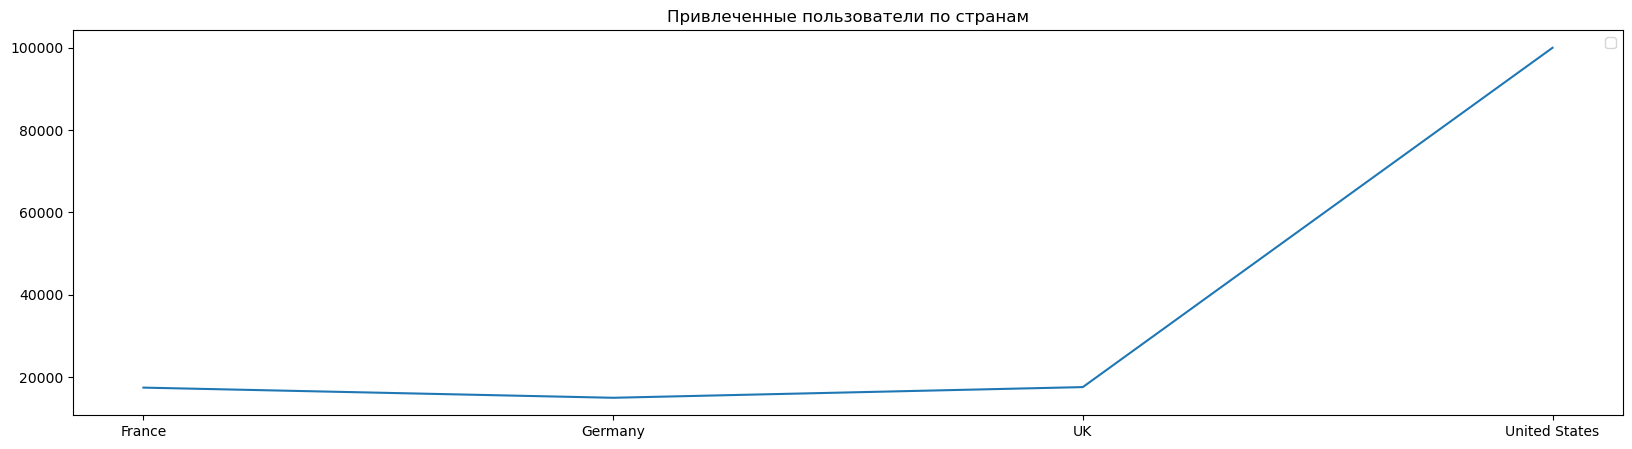

In [36]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.plot(regg['user_id'], label = 'user_id')
ax.set_title('Привлеченные пользователи по странам',loc='center')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


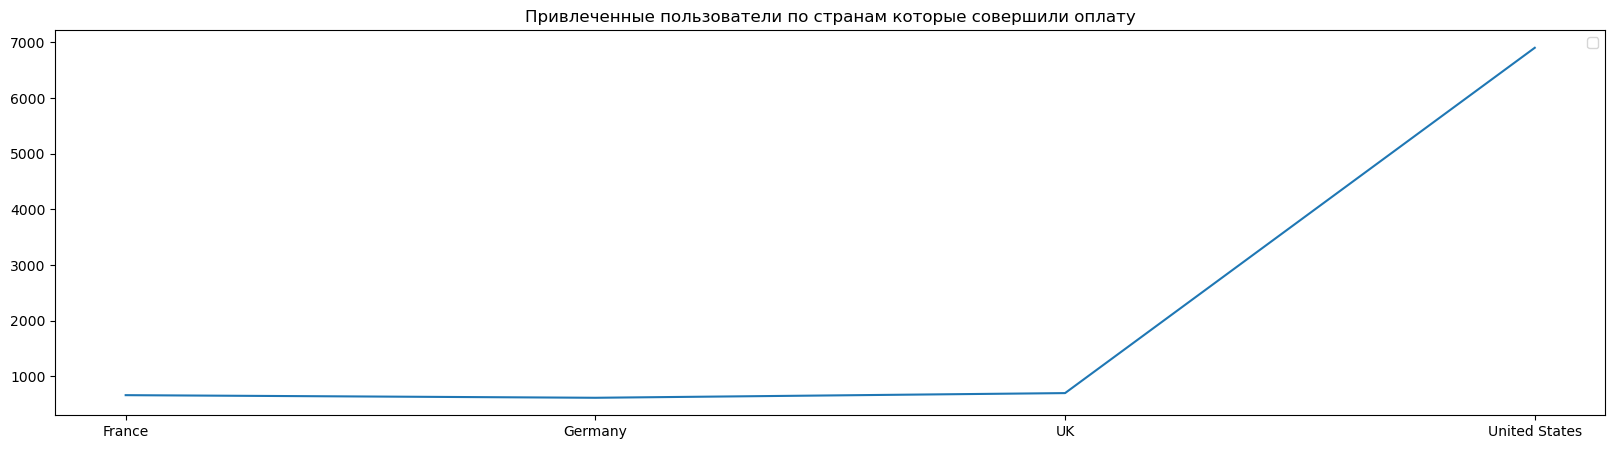

In [37]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.plot(regg['payer'], label = 'payer')
ax.set_title('Привлеченные пользователи по странам которые совершили оплату',loc='center')
plt.show()

Подавляющее большинство пользователей в том числе платящих в United States, отсальные страны +- на одном уровне.

In [38]:
#Какими устройствами пользуются клиенты и какими устройствами предпочитают пользоваться платящие пользователи.
dev_2 = profiles.groupby('device').agg({'user_id': 'count'})
dev_2['proc'] = (dev_2['user_id'] / dev_2['user_id'].sum() * 100).round(2).astype(str) + '%'
dev_2['payer'] = profiles.query('payer == True').groupby('device')['user_id'].count()
dev_2['proc_payer'] = (dev_2['payer'] / dev_2['user_id'] * 100).round(2).astype(str) + '%'
dev_2

user_id    proc  payer proc_payer
device                                    
Android    35032  23.35%   2050      5.85%
Mac        30042  20.03%   1912      6.36%
PC         30455   20.3%   1537      5.05%
iPhone     54479  36.32%   3382      6.21%

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


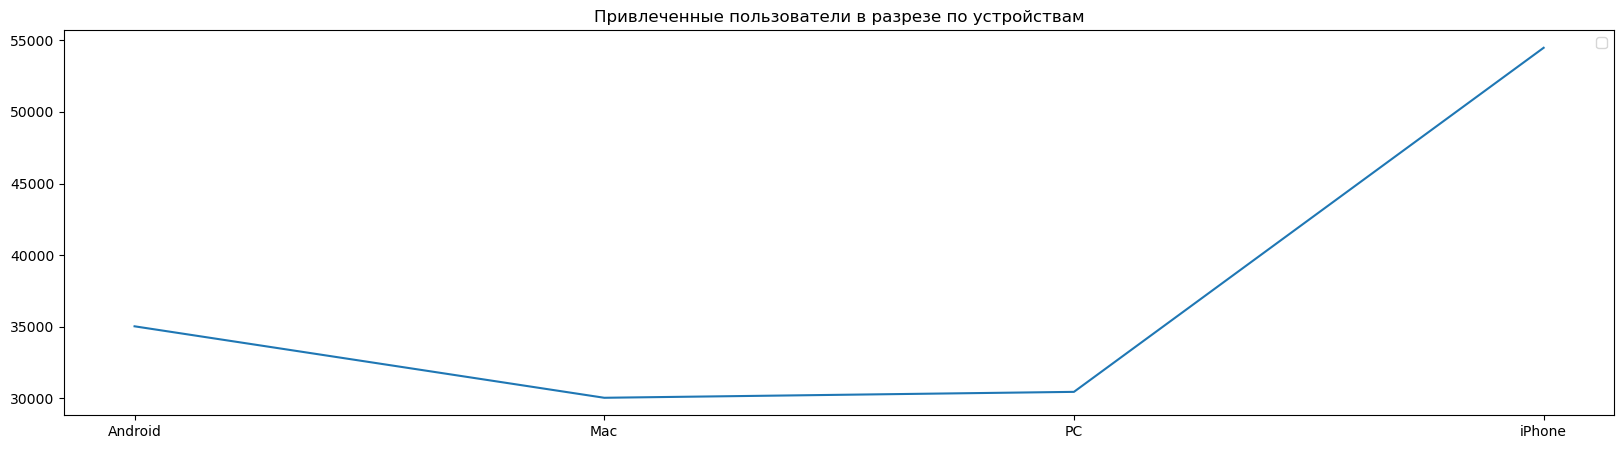

In [39]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.plot(dev_2['user_id'], label = 'user_id')
ax.set_title('Привлеченные пользователи в разрезе по устройствам',loc='center')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


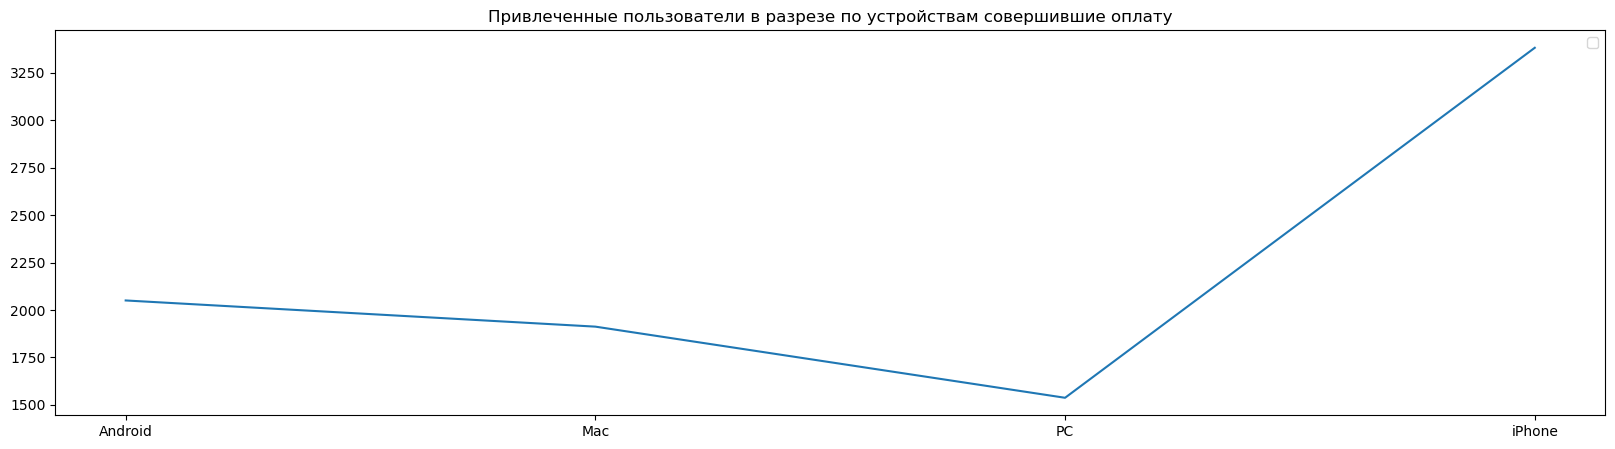

In [40]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.plot(dev_2['payer'], label = 'payer')
ax.set_title('Привлеченные пользователи в разрезе по устройствам совершившие оплату',loc='center')
plt.show()

По привлеченным пользователям выделяется iPhone, далее Android, Mac и PC примерно на одном уровне. По пользователям совершившим оплату в процентном соотношении от общего количество пользователей по утсройству лидирует Mac, немного отстает iPhone, PC отстает значительно от всей тройки.

In [41]:
#Выясняем из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих.
chan_2 = profiles.groupby('channel').agg({'user_id': 'count'})
chan_2['proc'] = (chan_2['user_id'] / chan_2['user_id'].sum() * 100).round(2).astype(str) + '%'
chan_2['payer'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
chan_2['proc_payer'] = (chan_2['payer'] / chan_2['user_id'] * 100).round(2).astype(str) + '%'
chan_2.sort_values('payer', ascending = False)

user_id    proc  payer proc_payer
channel                                              
FaceBoom              29144  19.43%   3557      12.2%
TipTop                19561  13.04%   1878       9.6%
organic               56439  37.62%   1160      2.06%
WahooNetBanner         8553    5.7%    453       5.3%
AdNonSense             3880   2.59%    440     11.34%
RocketSuperAds         4448   2.97%    352      7.91%
LeapBob                8553    5.7%    262      3.06%
OppleCreativeMedia     8605   5.74%    233      2.71%
lambdaMediaAds         2149   1.43%    225     10.47%
YRabbit                4312   2.87%    165      3.83%
MediaTornado           4364   2.91%    156      3.57%

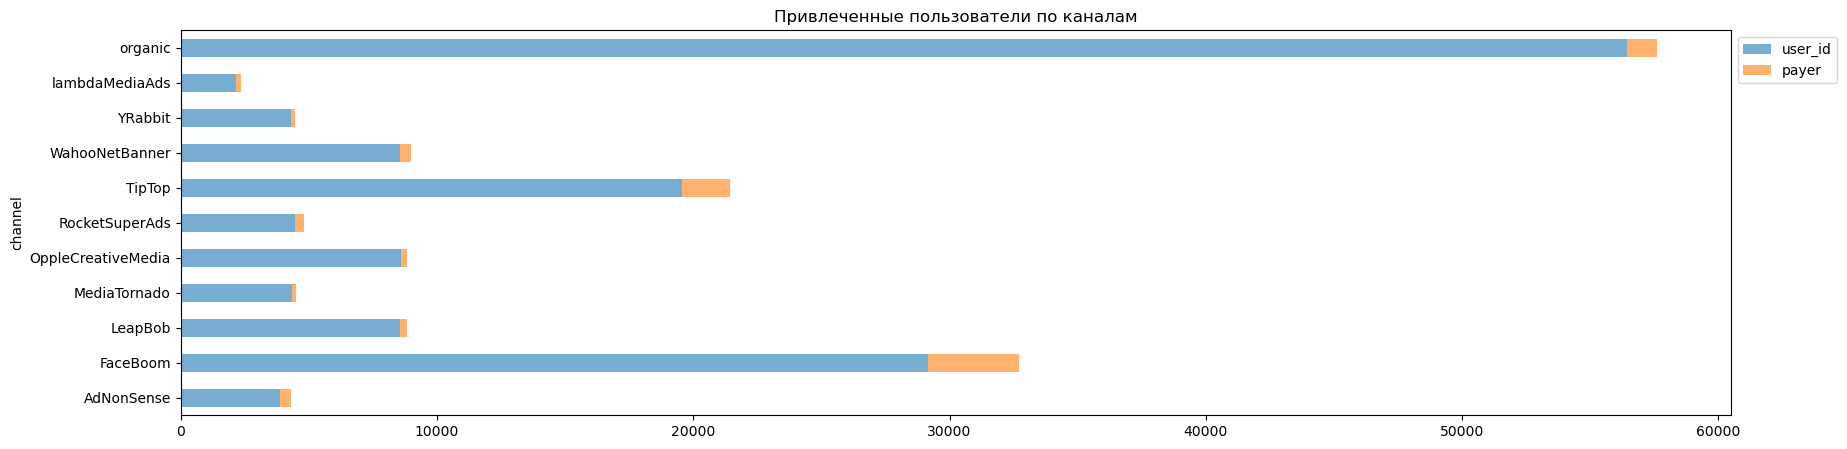

In [42]:
fig, ax = plt.subplots(figsize=(20, 5))
chan_2[['user_id', 'payer']].plot(kind='barh', stacked=True, ax=ax, alpha=0.6)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_title('Привлеченные пользователи по каналам',loc='center')
plt.show()

Значительно выделяется organic, но при этом у него самая маленькая доля конверсии. Далее по проценту пользователей выделяется FaceBoom и TipTop, эти два каналам забрали на себя более 30%. FaceBoom так же лидирует по проценту платящих пользователей,а TipTop немного сдал позиции, его обогнали AdNonSense и lambdaMediaAds.

**Вывод**: исследовательский анализ данных показал, что пользователи преимущественно из США, используют устройство IPhone и FaceBoom. Лидирующие каналы по пользователям которые готовы платить FaceBoom, TipTop, AdNonSense и lambdaMediaAds.

### Маркетинг

In [43]:
#Считаем общую сумму расходов на маркетинг
r = costs.groupby('channel')['costs'].sum().sort_values(ascending = False)
print(r)
print(f'Всего траты на рекламу: {costs.costs.sum().round(0)}')

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64
Всего траты на рекламу: 105497.0


Значительно больше приложение вкладывает в рекламу на каналы TipTop и FaceBoom. Общие траты составляют 105497.

Text(0, 0.5, 'Сумма')

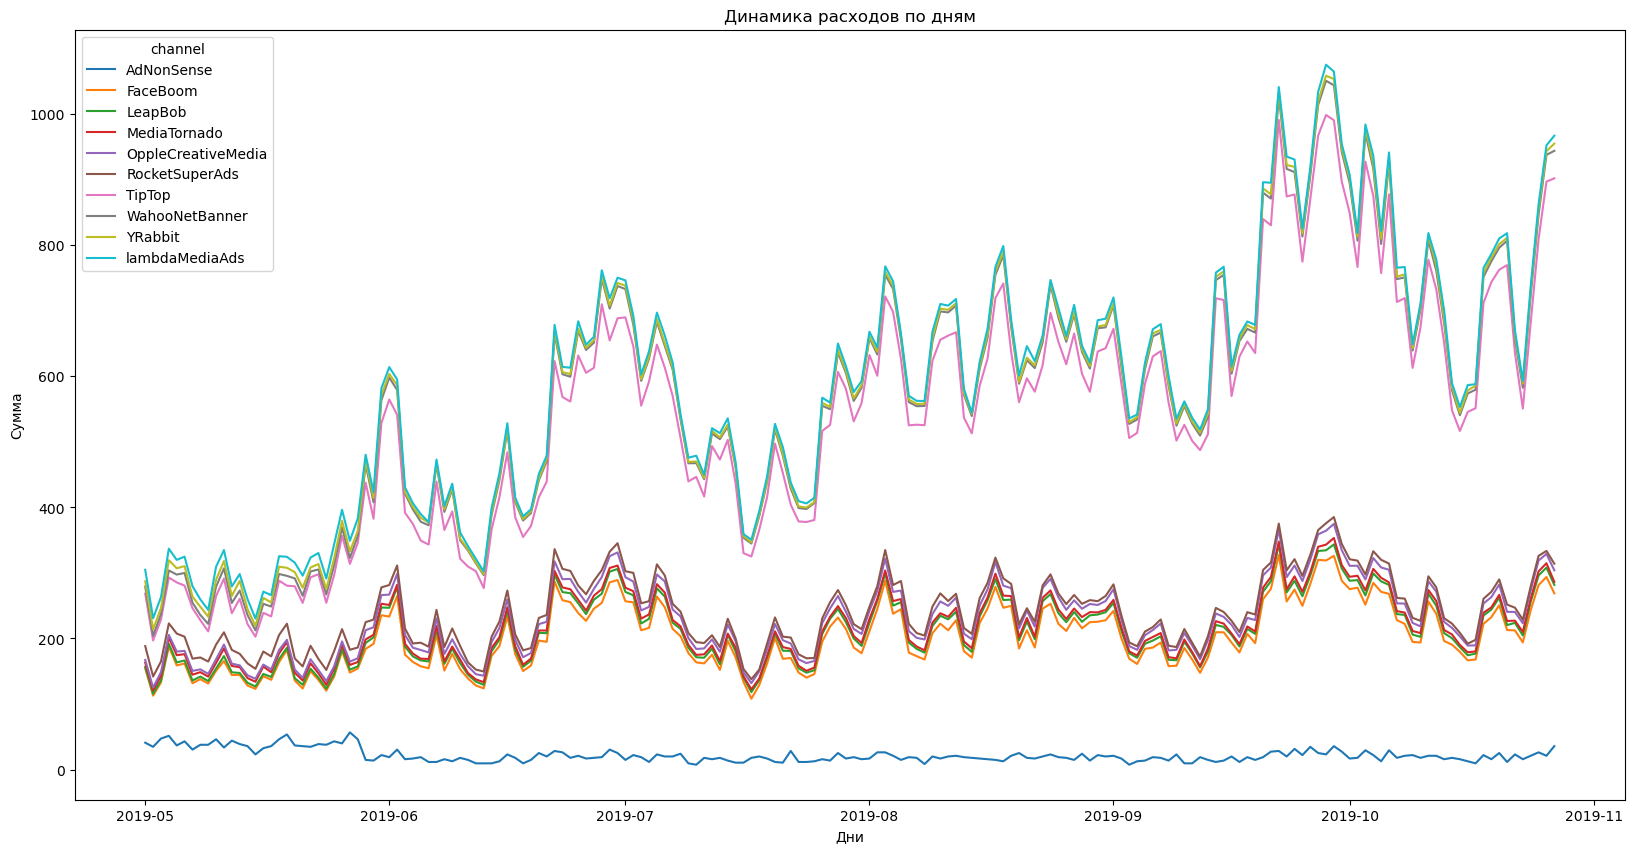

In [44]:
fig, ax = plt.subplots(figsize=(20, 10))
r_2 = costs.pivot_table(index = 'dt',columns = 'channel', values = 'costs', aggfunc = 'sum')
r_2_grafik = costs.pivot_table(index = 'dt',columns = 'channel', values = 'costs', aggfunc = 'sum').plot(ax = ax, stacked=True)
plt.title("Динамика расходов по дням")
plt.xlabel("Дни")
plt.ylabel("Сумма")

In [45]:
print(r_2)

channel     AdNonSense  FaceBoom  LeapBob  MediaTornado  OppleCreativeMedia  \
dt                                                                            
2019-05-01       40.95     113.3     2.52          6.24                4.25   
2019-05-02       34.65      78.1     2.94          5.04                4.25   
2019-05-03       47.25      85.8     2.73          6.96                5.75   
2019-05-04       51.45     136.4     3.99          9.36                4.25   
2019-05-05       36.75     122.1     4.62         11.04                5.50   
...                ...       ...      ...           ...                 ...   
2019-10-23       15.75     178.2    10.71          5.28               13.25   
2019-10-24       21.00     222.2    12.81          5.04               12.50   
2019-10-25       26.25     255.2    14.70          6.24               16.50   
2019-10-26       21.00     272.8    14.28          6.72               14.25   
2019-10-27       35.70     233.2    12.81          4

In [46]:
#Добавим столбцы с неделей и месяцем
test_costs = costs
test_costs['dt'] = pd.to_datetime(costs['dt'])
test_costs['month'] = test_costs['dt'].dt.month
test_costs['week'] = pd.DatetimeIndex(test_costs['dt']).week
print(test_costs)

             dt         channel  costs  month  week
0    2019-05-01        FaceBoom  113.3      5    18
1    2019-05-02        FaceBoom   78.1      5    18
2    2019-05-03        FaceBoom   85.8      5    18
3    2019-05-04        FaceBoom  136.4      5    18
4    2019-05-05        FaceBoom  122.1      5    18
...         ...             ...    ...    ...   ...
1795 2019-10-23  lambdaMediaAds    4.0     10    43
1796 2019-10-24  lambdaMediaAds    6.4     10    43
1797 2019-10-25  lambdaMediaAds    8.8     10    43
1798 2019-10-26  lambdaMediaAds    8.8     10    43
1799 2019-10-27  lambdaMediaAds   12.0     10    43

[1800 rows x 5 columns]


C:\Users\Andrey\AppData\Local\Temp\ipykernel_1596\1414105803.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  test_costs['week'] = pd.DatetimeIndex(test_costs['dt']).week


Text(0, 0.5, 'Сумма')

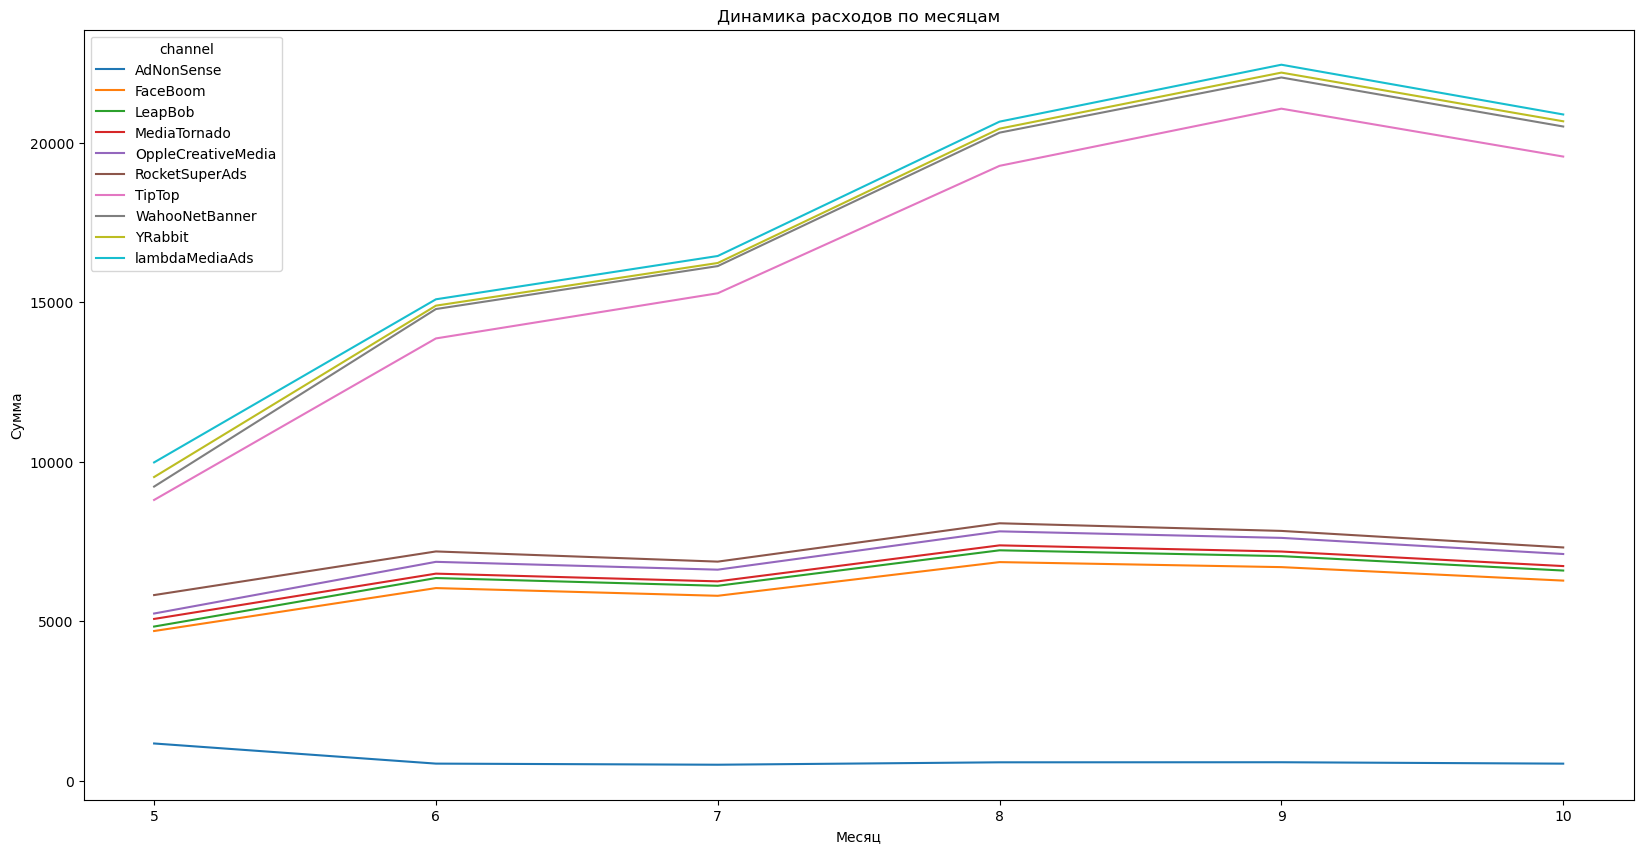

In [47]:
#Строим график по месяцам 
fig, ax = plt.subplots(figsize=(20, 10))
test_grafik = test_costs.pivot_table(index = 'month',columns = 'channel', values = 'costs', aggfunc = 'sum').plot(ax = ax, stacked=True)
plt.title("Динамика расходов по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Сумма")

Text(0, 0.5, 'Сумма')

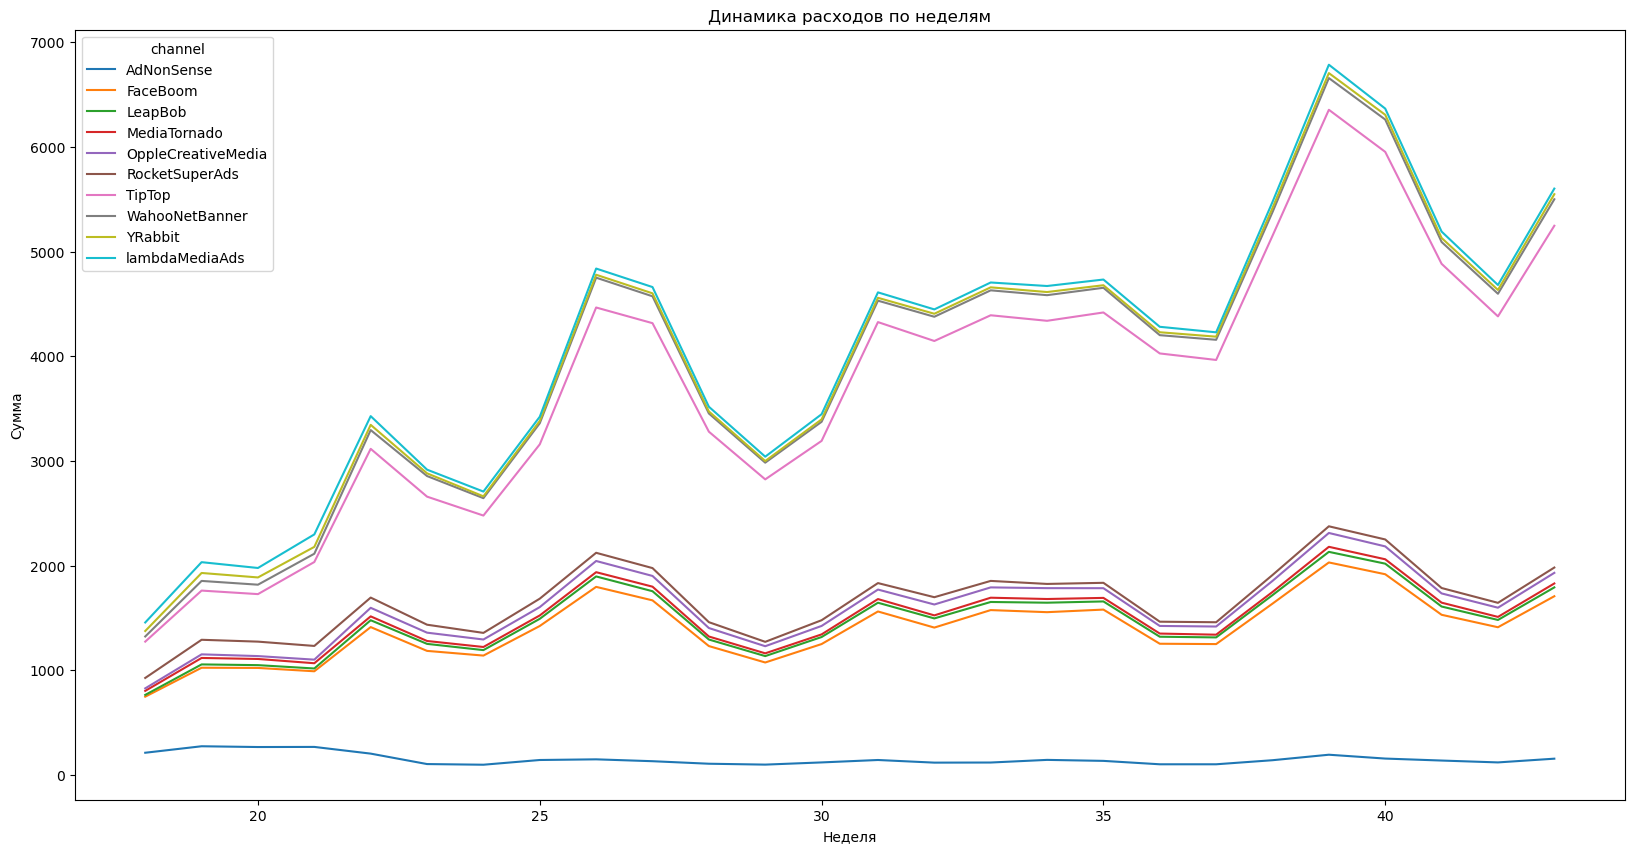

In [48]:
#Строим график по неделям
fig, ax = plt.subplots(figsize=(20, 10))
test_grafik_2 = test_costs.pivot_table(index = 'week',columns = 'channel', values = 'costs', aggfunc = 'sum').plot(ax = ax, stacked=True)
plt.title("Динамика расходов по неделям")
plt.xlabel("Неделя")
plt.ylabel("Сумма")

На графиках отражена динамика по дням, неделям и месяцам. Видим, что по каналам траты растут вплоть до 9 месяца включительно(при этом по дням и неделям были взлёты и падения), после 9 месяца идёт медленное падание. Динамика взлетов и падения топ-каналов и каналов на которые приходится меньше трат похожа, следовательно траты повышались и понижались одинаково в процентном соотношении.

In [49]:
#Считаем CaC по каналам.
costs_channel = (profiles.pivot_table(index = 'channel', values = 'acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', ascending=False))
costs_channel

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

In [50]:
print(f'средний CAC: {profiles.acquisition_cost.mean()}')

средний CAC: 0.7032778251826568


In [51]:
print('Средний CAC без organic:')
print(profiles.query('channel != "organic"').agg({'acquisition_cost': 'mean'}))

Средний CAC без organic:
acquisition_cost    1.127481
dtype: float64


В таблице отображено сколько стоило в среднем привлечение пользователя по каналам. Дороже всего обходится TipTop, дешевле LeapBob. Organic можно исключить из этих расчетов и расчетов в дальнейшем, так как они ничего не стоят компании.

### Окупаемость рекламы

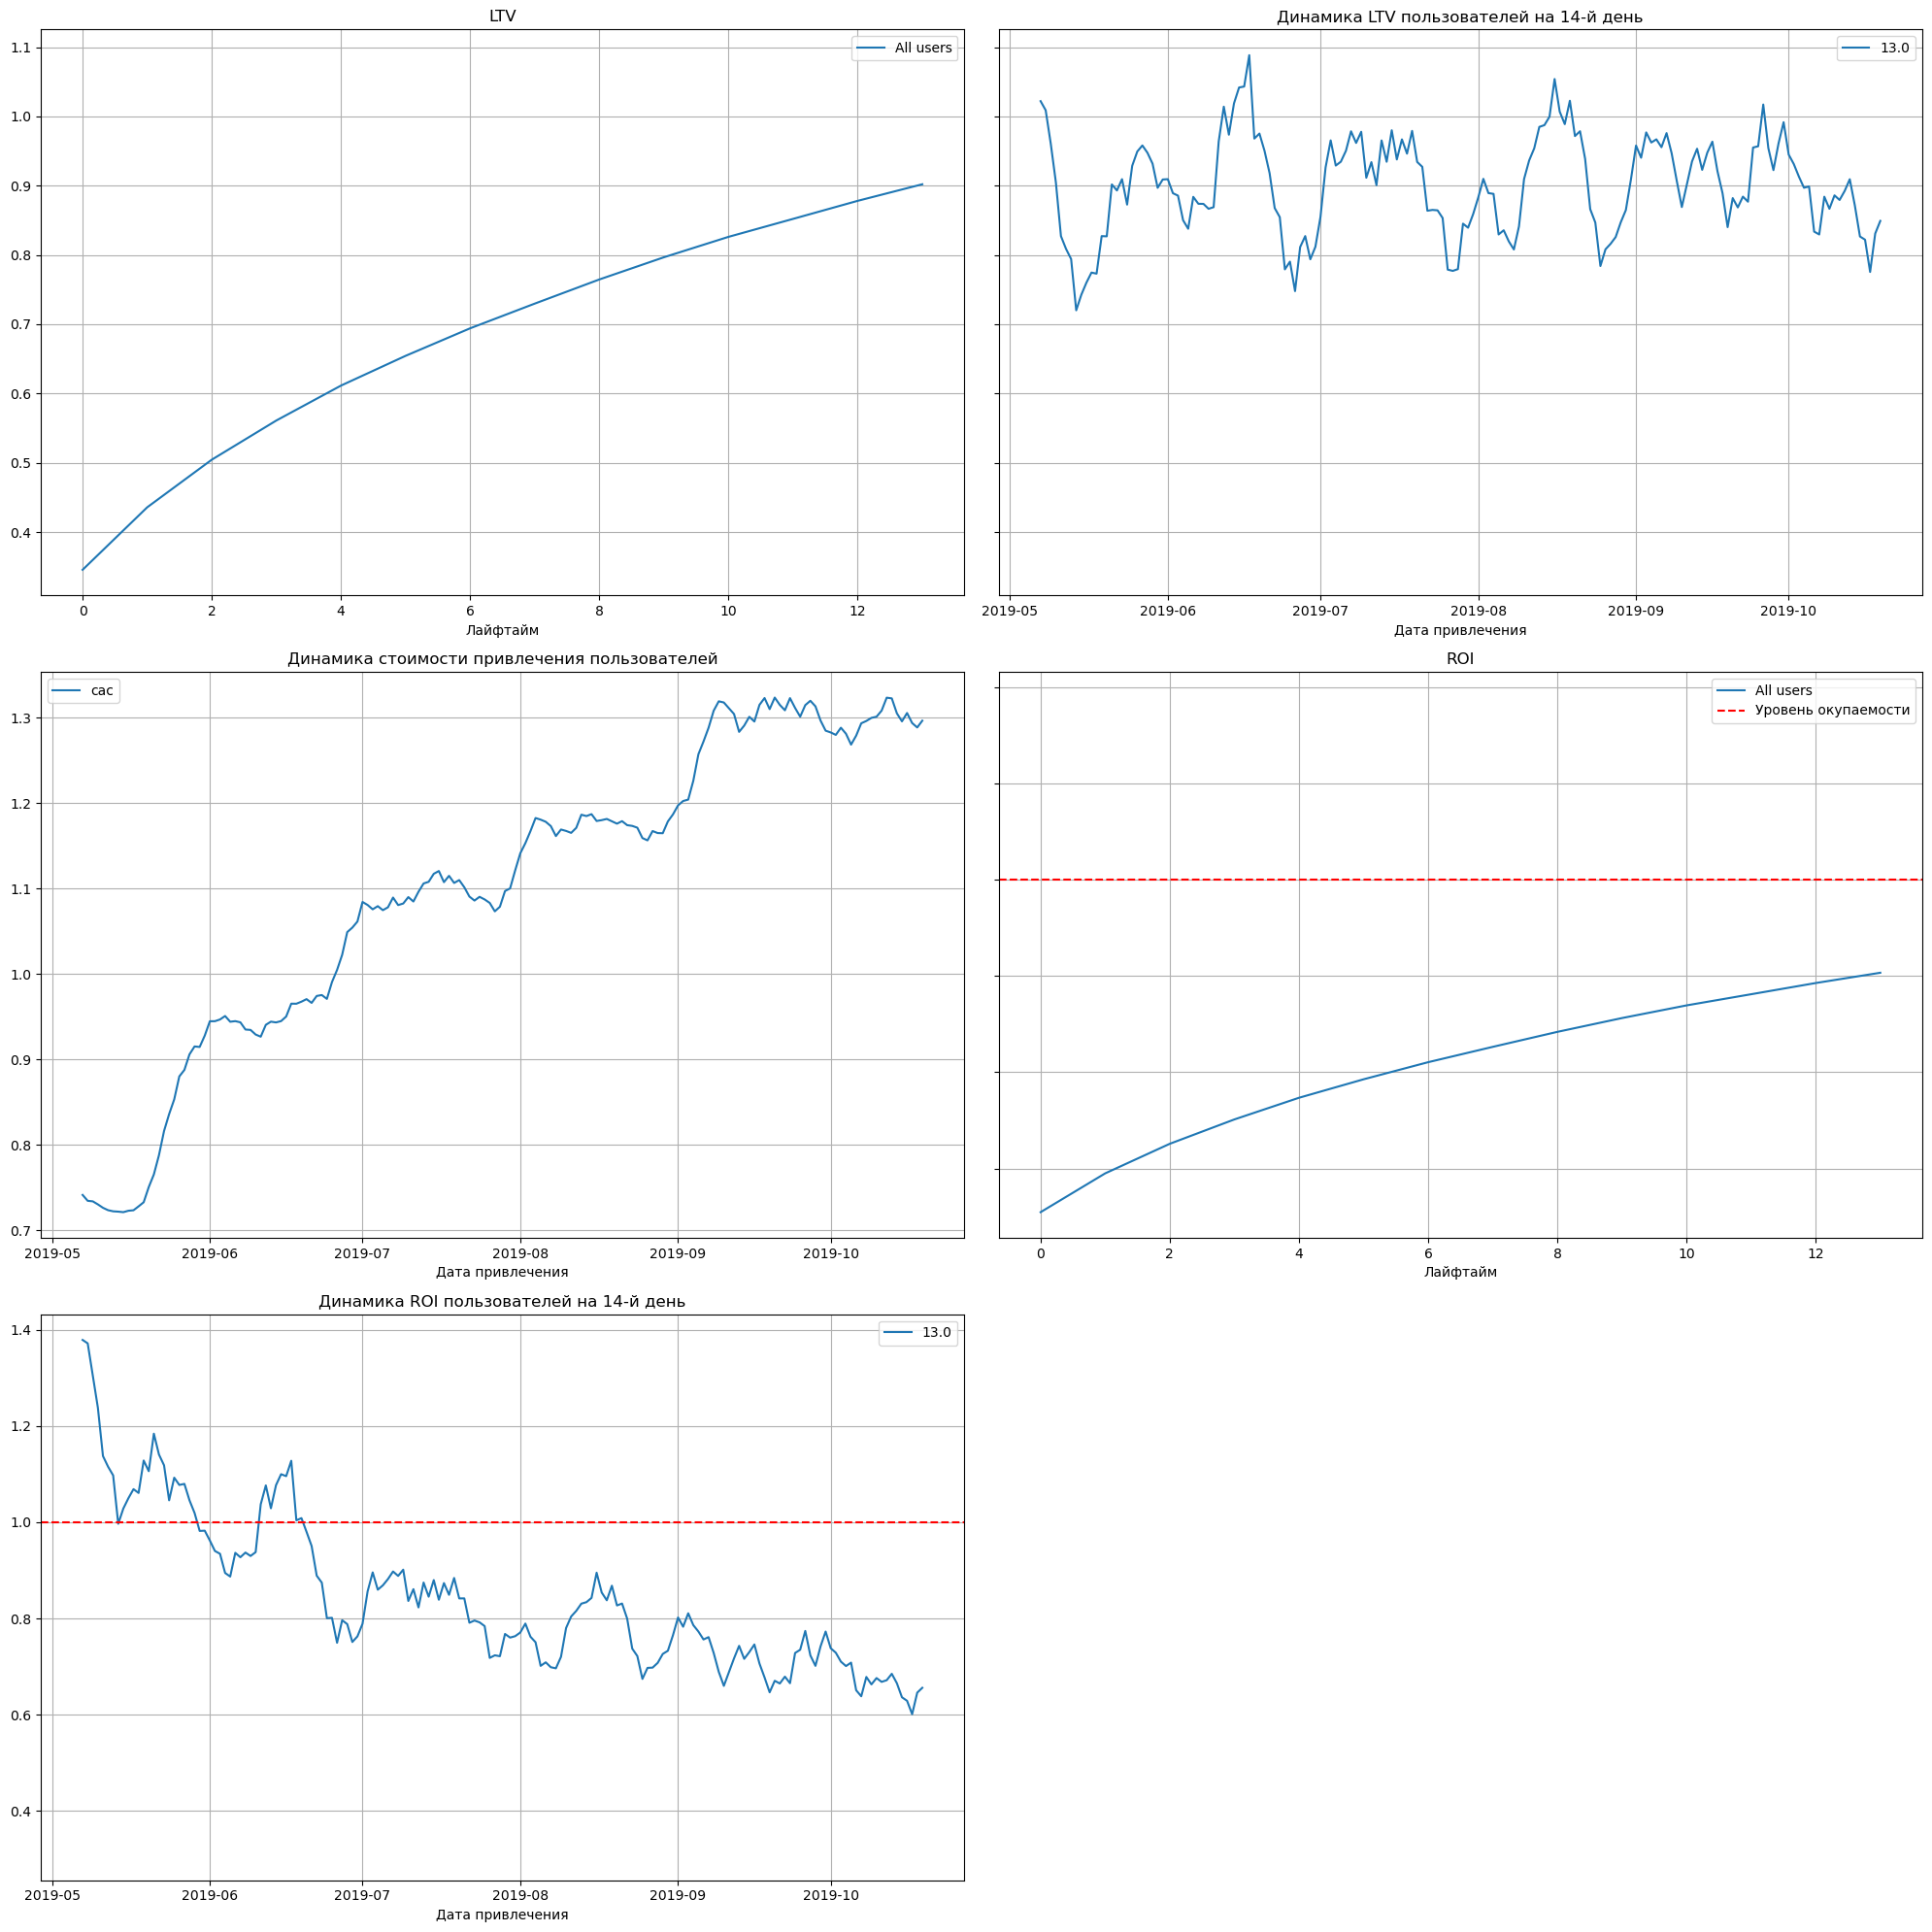

In [52]:
#Анализируем окупаемость с помощью графиков LTV, ROI и CAC.
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
analysis_horizon = 14
profiles = profiles.query('channel != "organic"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(profiles, orders, observation_date, analysis_horizon)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

С июня динамика окупаемости стремится вниз.

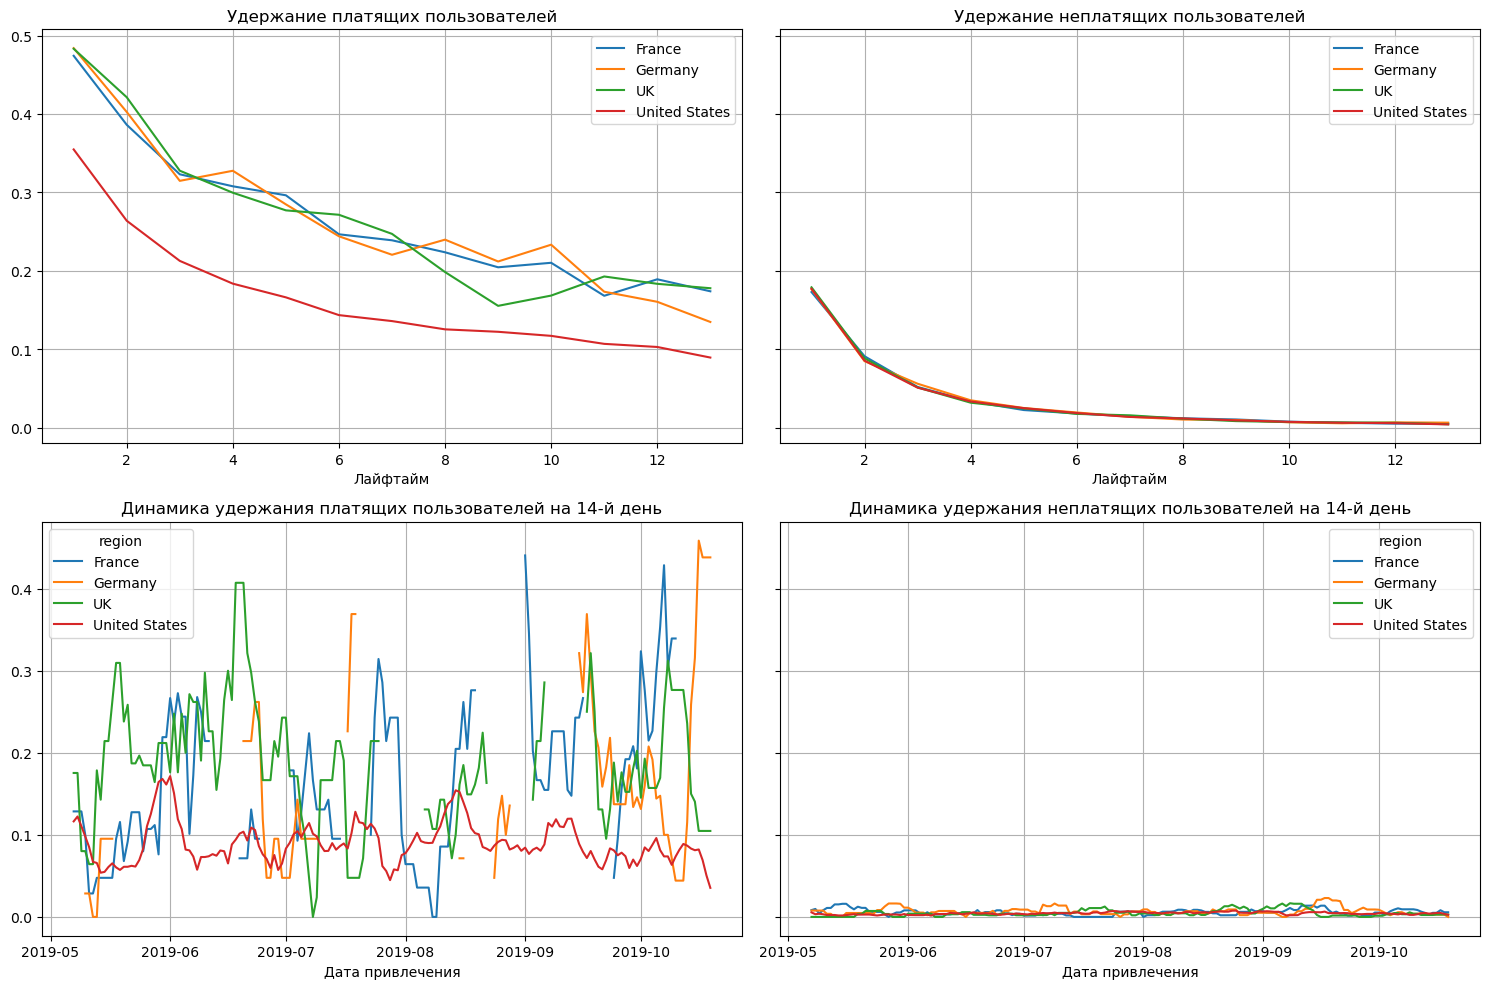

In [53]:
#Retention Rate по странам
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, analysis_horizon, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, analysis_horizon)


В США худшее удержание платящих пользователей.

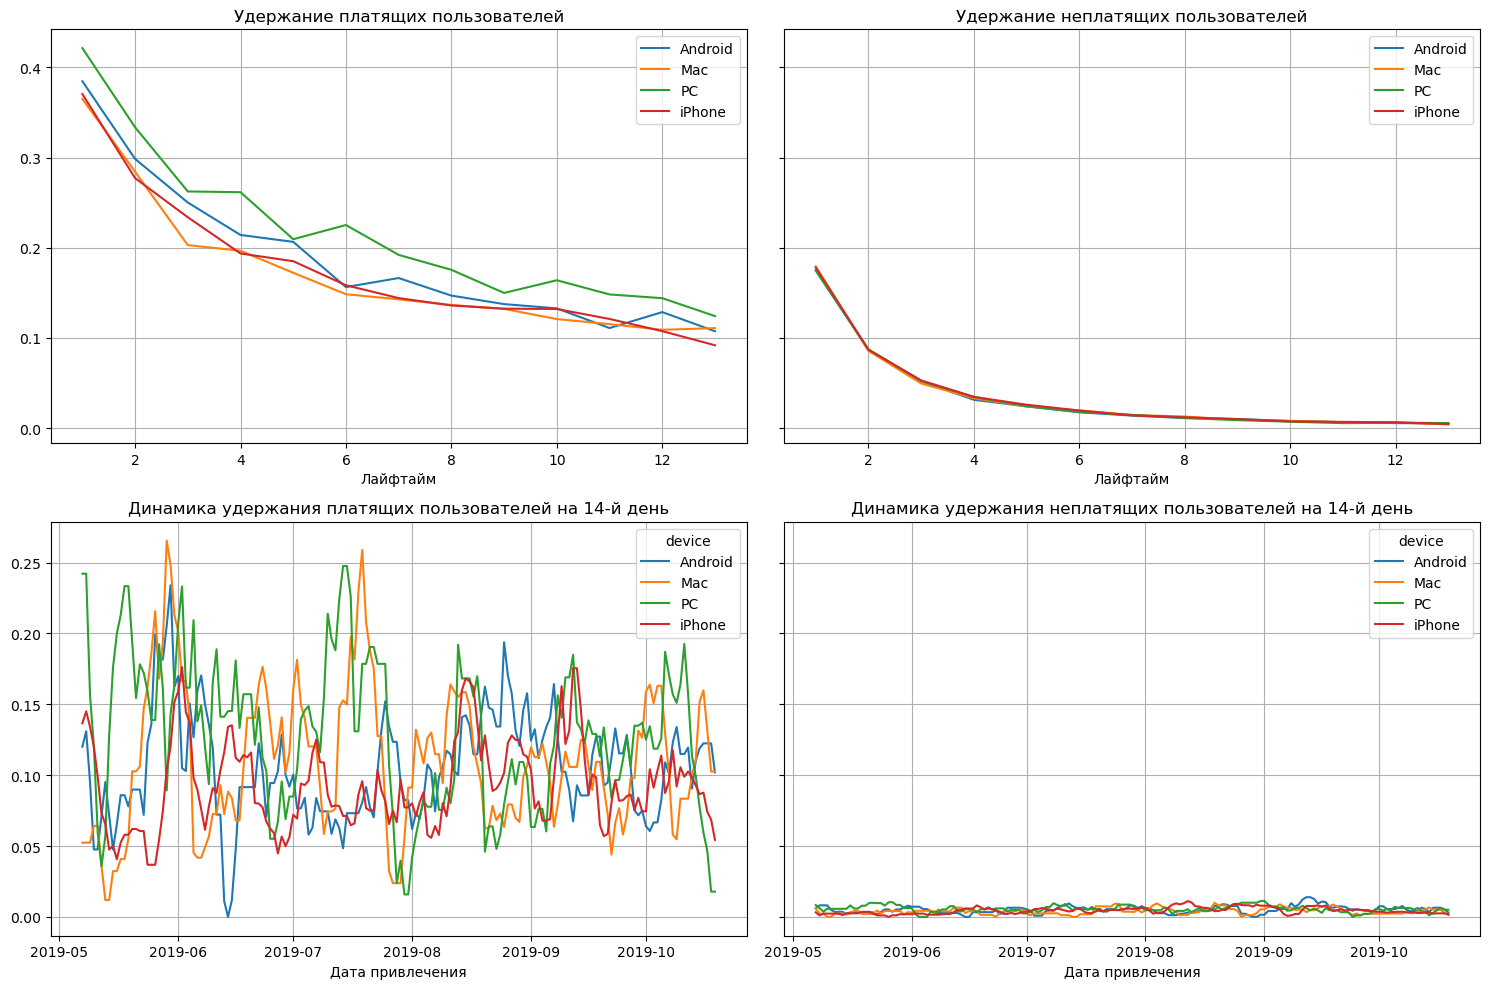

In [54]:
#Retention Rate по устройствам
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, analysis_horizon, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, analysis_horizon)

Удержание платящих пользователей лучше у ПК, в остальном каких либо закономерностей не наблюдается.

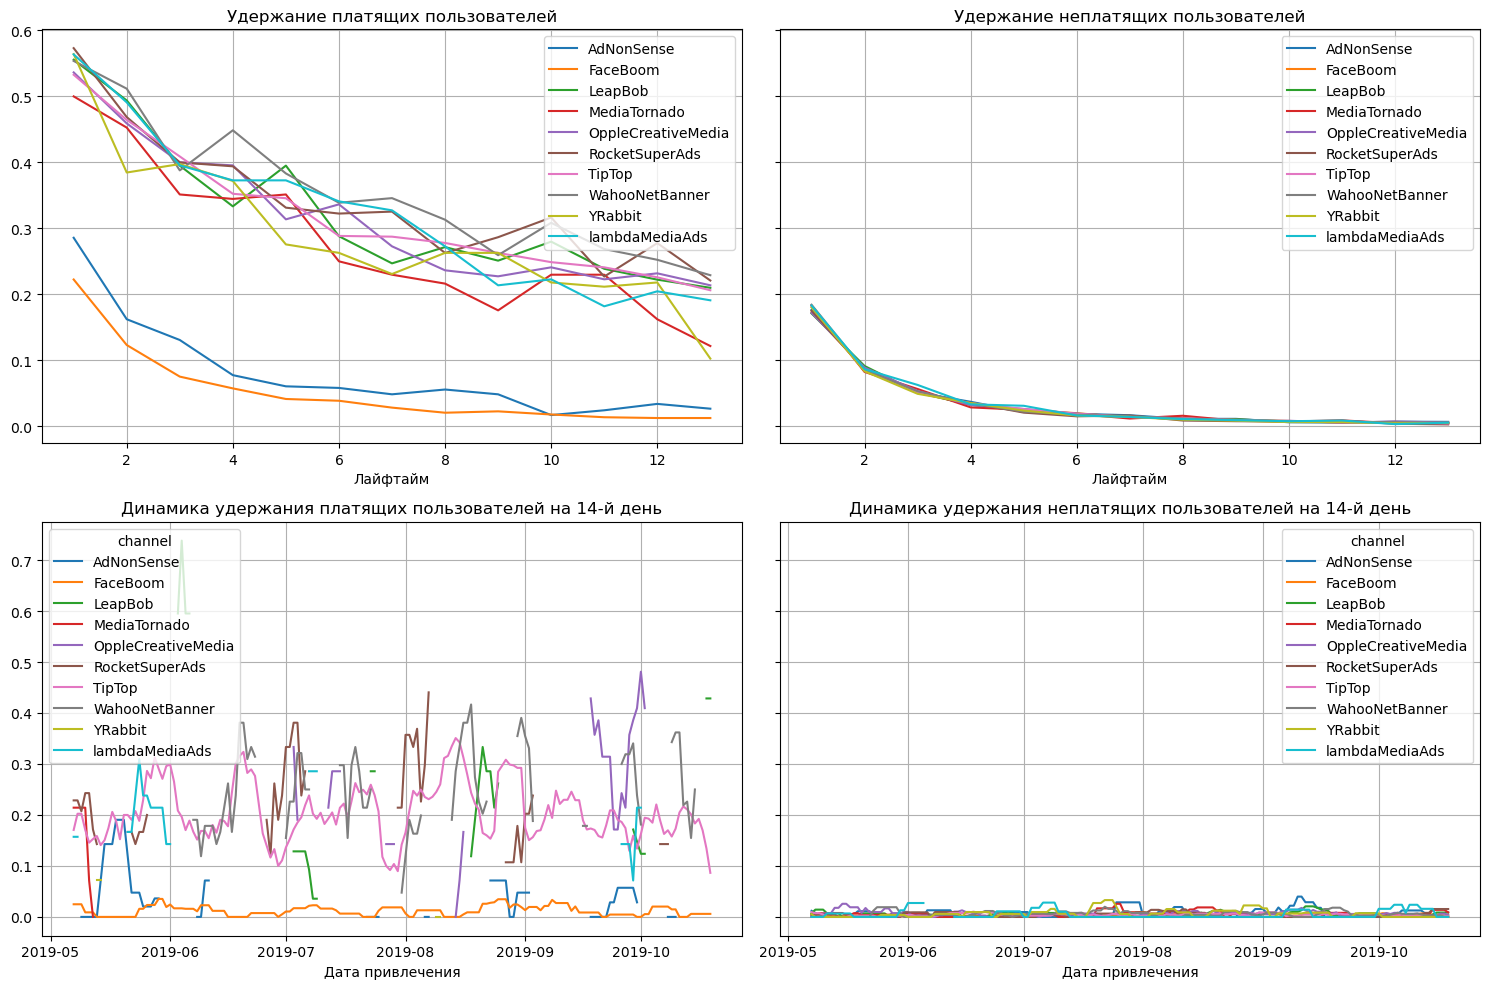

In [55]:
#Retention Rate по каналам
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, analysis_horizon, dimensions=dimensions)
plot_retention(retention_grouped, retention_history, analysis_horizon)

FaceBoom и AdNonSense показывают значительно худшее удержание по сравнению с другими каналами.

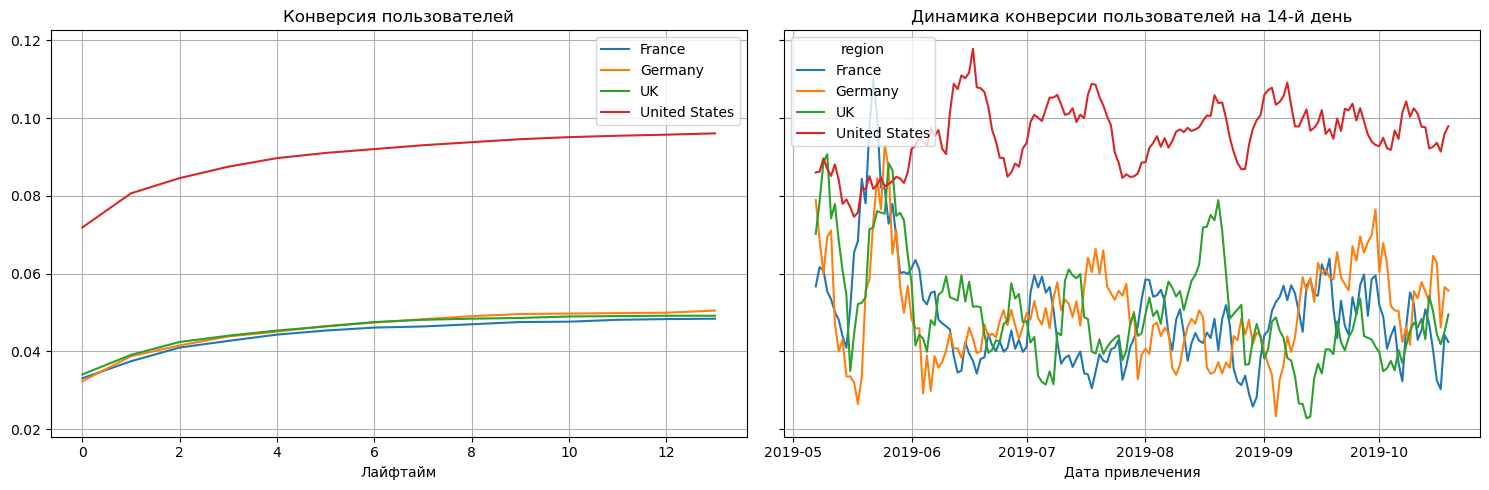

In [56]:
#Конверсия по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, analysis_horizon, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, analysis_horizon)


Конверсия в США в разы превышает конверсию других стран.

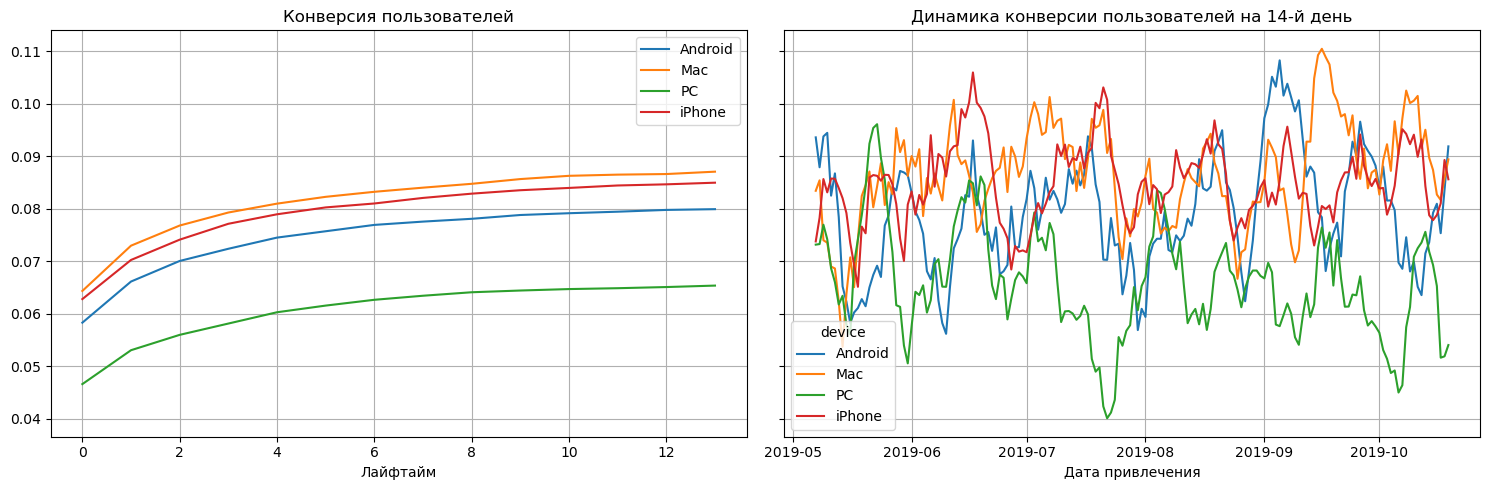

In [57]:
#Конверсия по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, analysis_horizon, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

У PC конверсия пользователей сильно ниже конверсий других устройств.

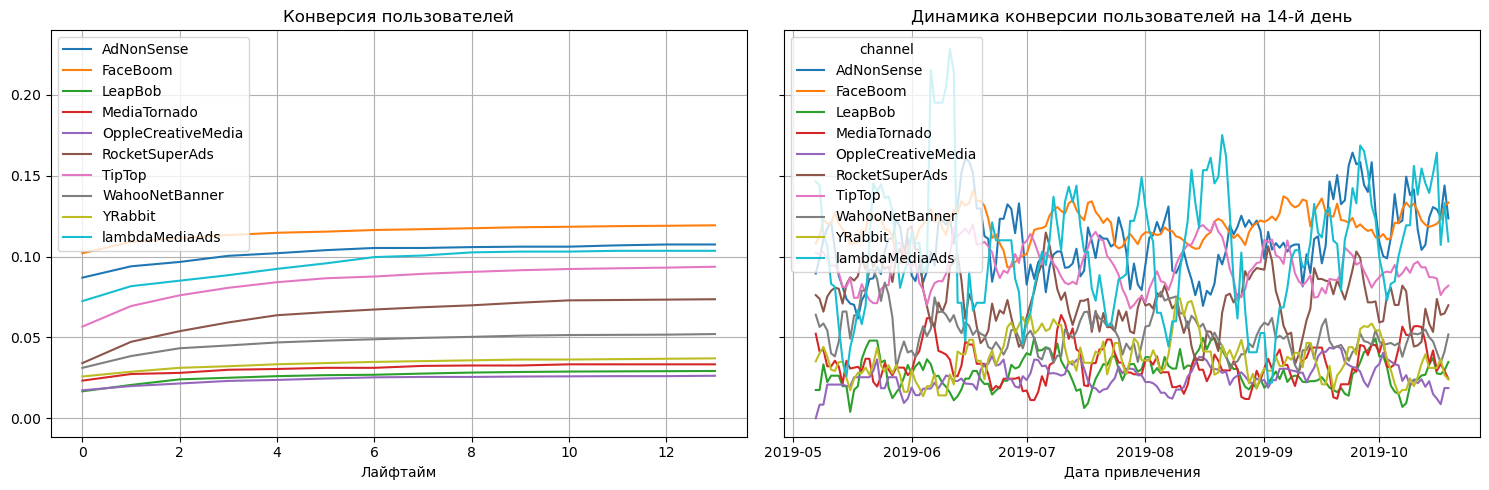

In [58]:
#Конверсия по каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, analysis_horizon, dimensions=dimensions)
plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

Как таковой динамики конверсии по каналам нет. Выше всего конверсия у FaceBoom, AdNonSense и LambdaMediaAds.

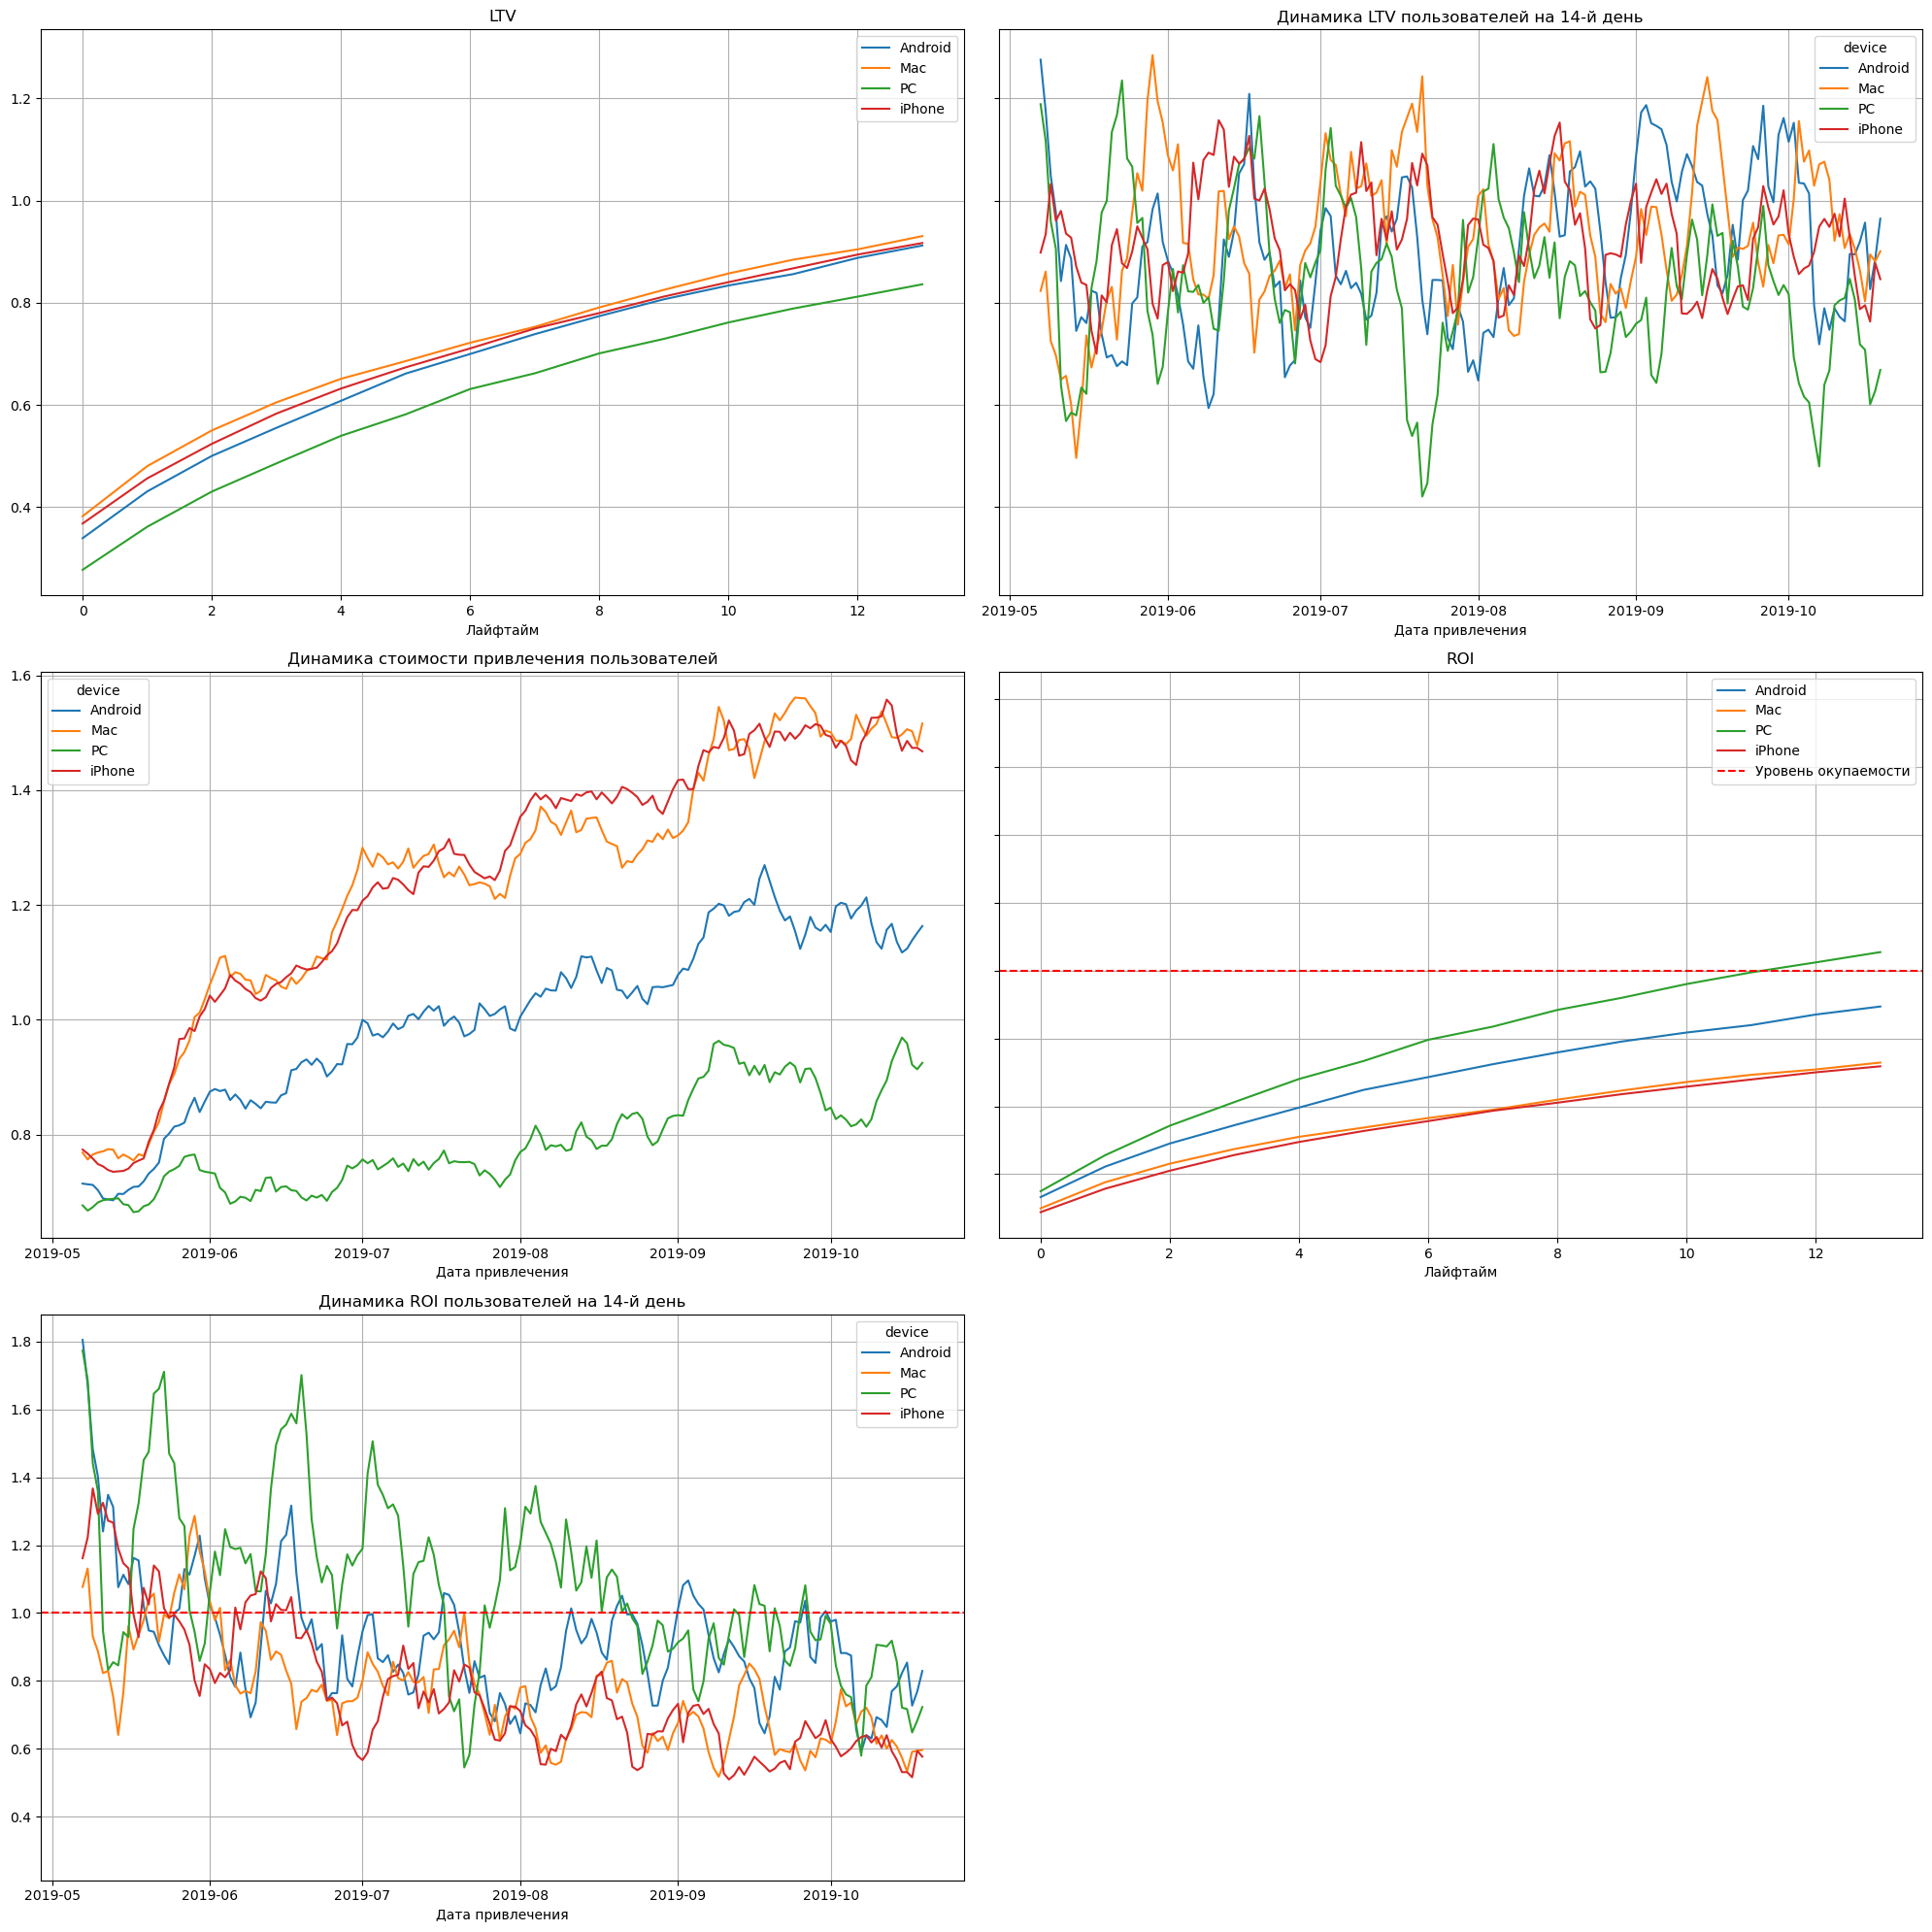

cohort_size       0.0       1.0       2.0       3.0       4.0  \
device                                                                   
Android        20683  0.339218  0.430766  0.500209  0.555218  0.608159   
Mac            17747  0.382235  0.480219  0.550124  0.605077  0.651197   
PC             18128  0.277400  0.361536  0.430422  0.485652  0.539617   
iPhone         32086  0.367928  0.456307  0.523902  0.583165  0.632132   

              5.0       6.0       7.0       8.0       9.0      10.0      11.0  \
device                                                                          
Android  0.661395  0.699810  0.738562  0.773986  0.806850  0.833871  0.856068   
Mac      0.685782  0.721831  0.752874  0.790957  0.825376  0.857376  0.884370   
PC       0.581623  0.631240  0.661959  0.701004  0.729414  0.761510  0.788708   
iPhone   0.673563  0.710708  0.749656  0.779956  0.812214  0.840427  0.867426   

             12.0      13.0  
device                       
Android  0.887970  0.912098  
Mac      0.904617  0.930541  
PC       0.812106  0.836167  
iPhone   0.894400  0.916983

In [59]:
#Окупаемость рекламы с разбивкой по устройствам
dimensions = ['device']
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(profiles, orders, observation_date, analysis_horizon, dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)
ltv_grouped

На окупаемость выходят только устройства ПК. Самая высокая динамика стоимости привлечения у Iphone и Mac.

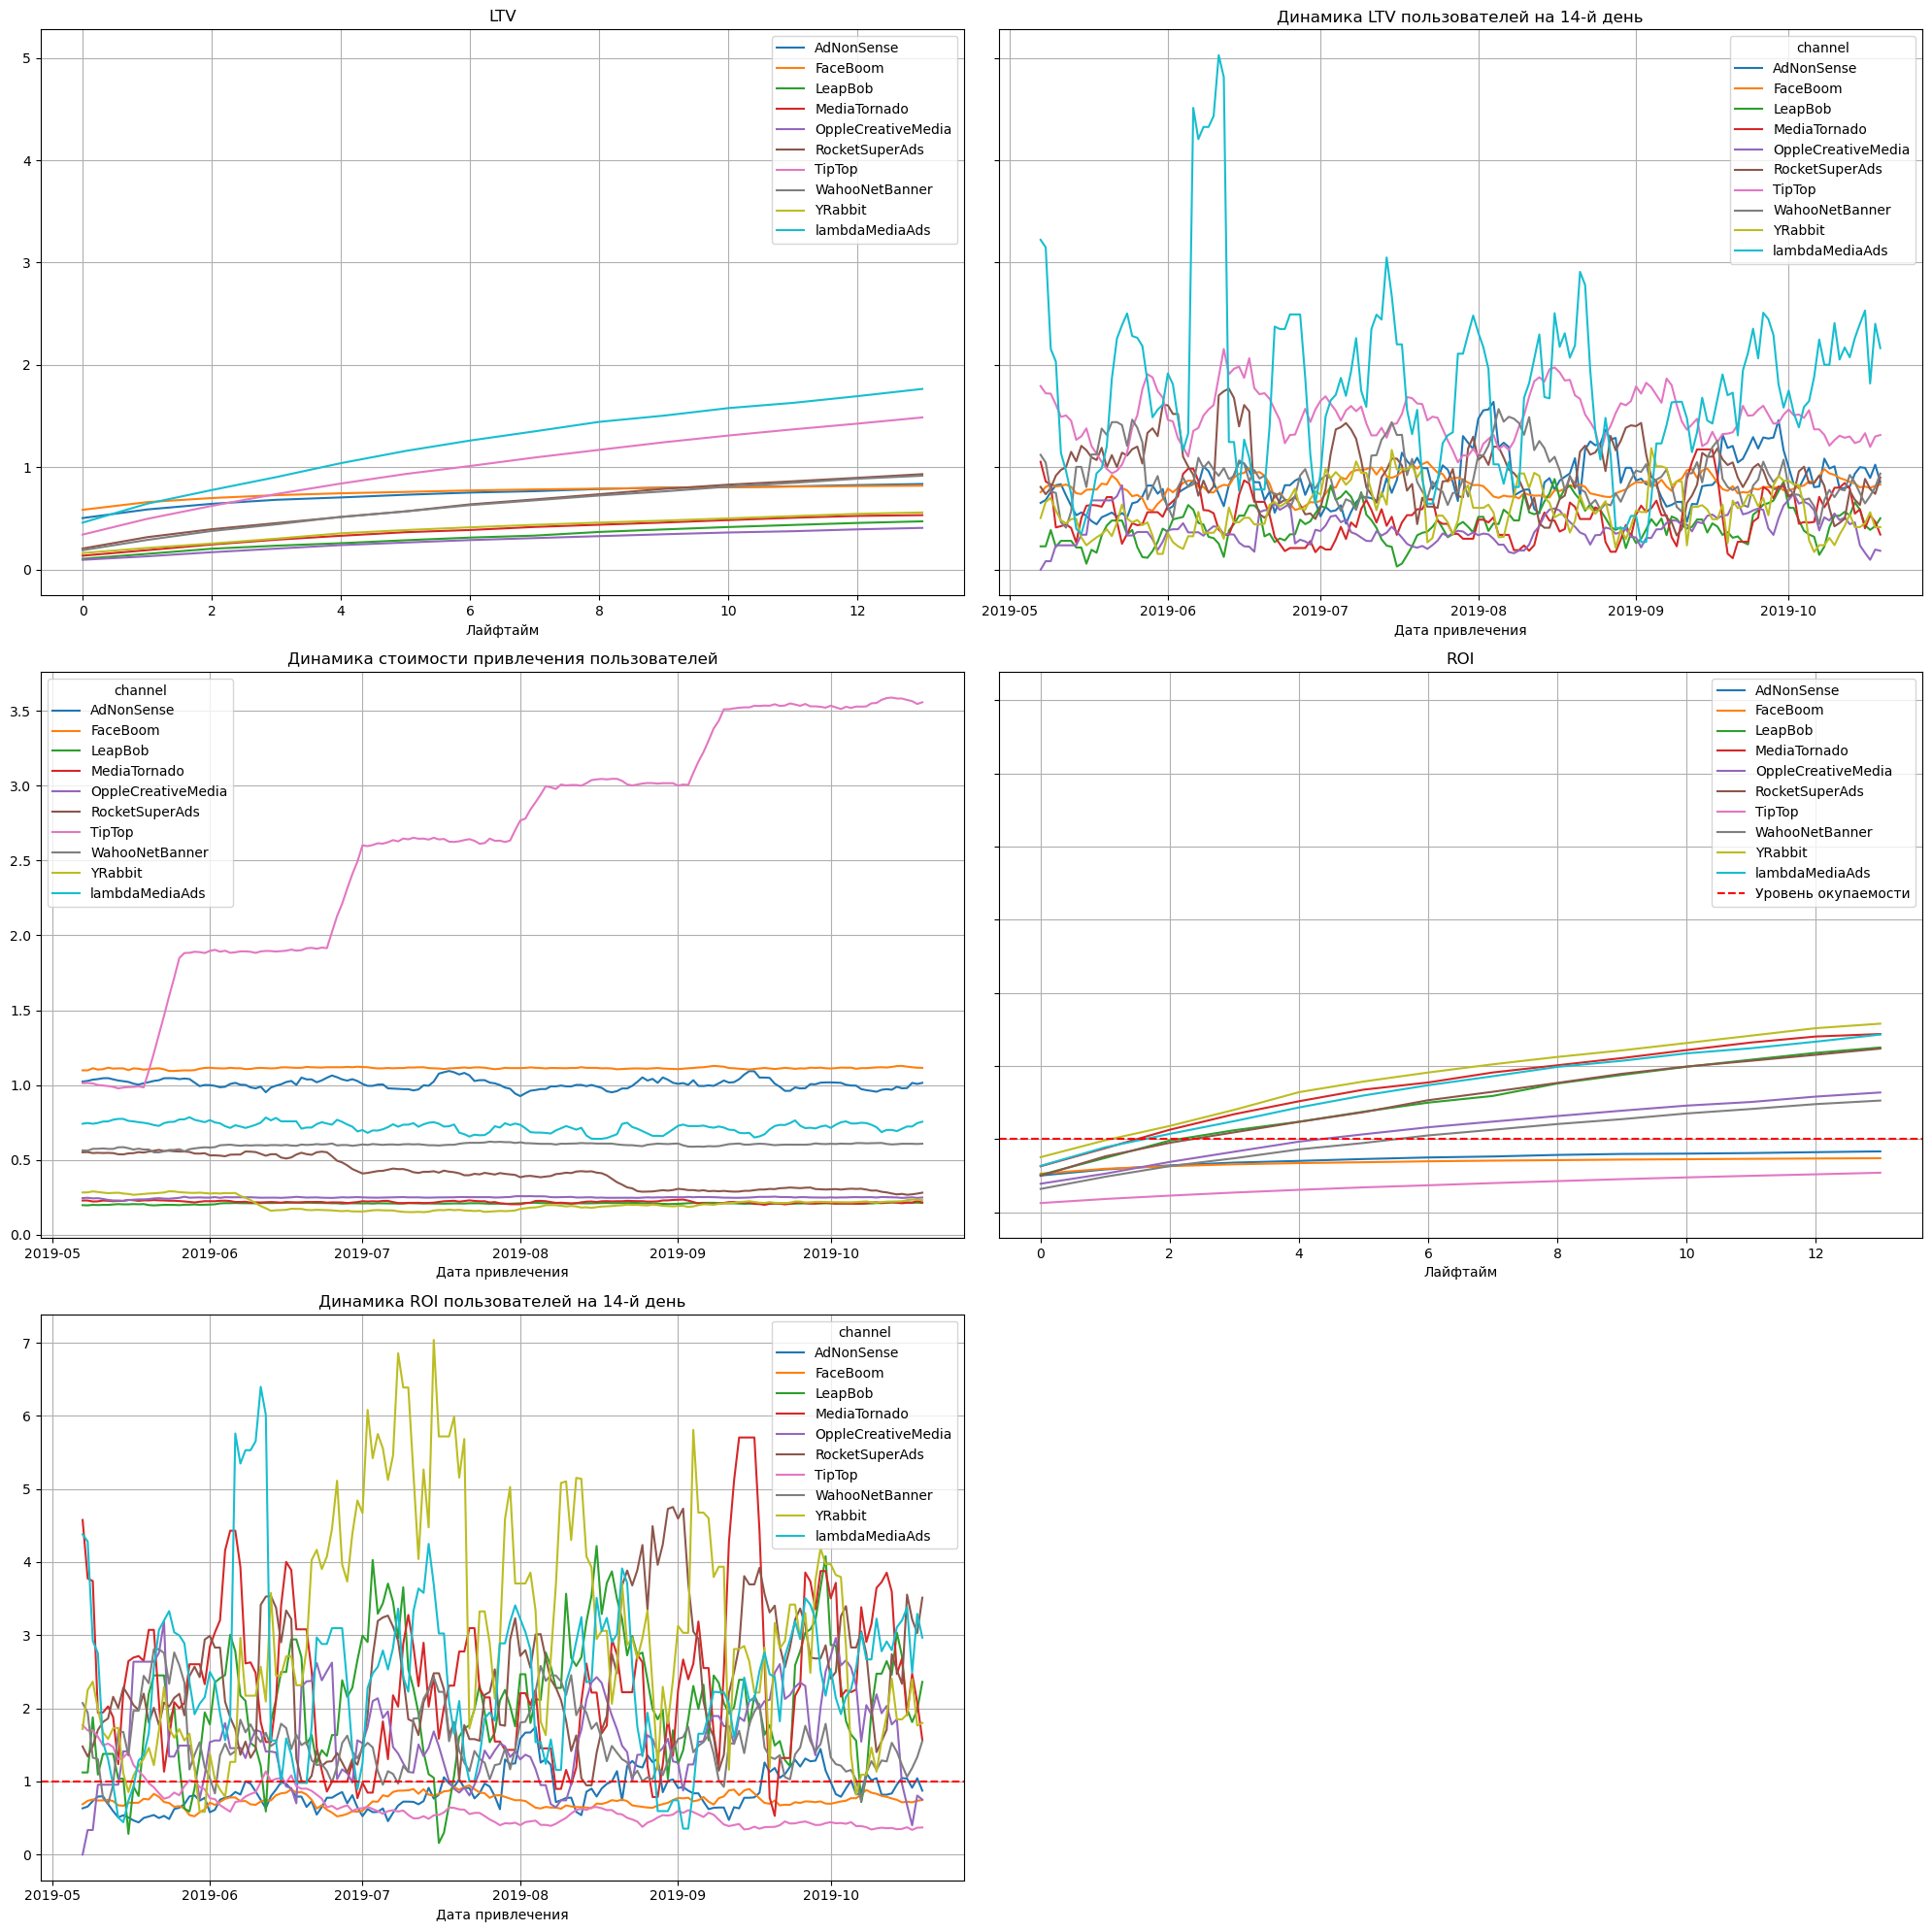

cohort_size       0.0       1.0       2.0       3.0  \
channel                                                                   
AdNonSense                 3702  0.505030  0.589149  0.644417  0.683509   
FaceBoom                  27544  0.585703  0.660825  0.700722  0.728842   
LeapBob                    8103  0.107048  0.155702  0.205583  0.235391   
MediaTornado               4167  0.137485  0.191615  0.246943  0.293667   
OppleCreativeMedia         8139  0.097239  0.131578  0.171686  0.206636   
RocketSuperAds             4251  0.207570  0.318640  0.396114  0.455980   
TipTop                    18498  0.343550  0.497389  0.624141  0.739834   
WahooNetBanner             8082  0.191302  0.291477  0.378921  0.443754   
YRabbit                    4102  0.163301  0.213423  0.256000  0.303932   
lambdaMediaAds             2056  0.460268  0.645302  0.778789  0.905540   

                         4.0       5.0       6.0       7.0       8.0  \
channel                                                                
AdNonSense          0.706694  0.732582  0.754149  0.767628  0.789203   
FaceBoom            0.747143  0.760369  0.774718  0.784757  0.792404   
LeapBob             0.259654  0.288599  0.314587  0.333802  0.369543   
MediaTornado        0.332249  0.366979  0.388534  0.418474  0.440034   
OppleCreativeMedia  0.241103  0.266240  0.290152  0.309527  0.328544   
RocketSuperAds      0.515613  0.571019  0.639125  0.687255  0.737986   
TipTop              0.842358  0.935707  1.013676  1.096450  1.171400   
WahooNetBanner      0.516862  0.569469  0.631870  0.678176  0.725353   
YRabbit             0.356265  0.387894  0.414656  0.438988  0.460885   
lambdaMediaAds      1.041503  1.160433  1.262369  1.352169  1.444888   

                         9.0      10.0      11.0      12.0      13.0  
channel                                                               
AdNonSense          0.802682  0.806996  0.815084  0.827215  0.838006  
FaceBoom            0.800775  0.806247  0.812226  0.817483  0.821469  
LeapBob             0.394176  0.417579  0.437902  0.457608  0.473004  
MediaTornado        0.461589  0.485541  0.508294  0.526256  0.533684  
OppleCreativeMedia  0.346938  0.364228  0.376613  0.395017  0.409118  
RocketSuperAds      0.790118  0.831437  0.864307  0.898586  0.933801  
TipTop              1.245485  1.311417  1.371467  1.427640  1.487908  
WahooNetBanner      0.765488  0.812535  0.849334  0.889472  0.918615  
YRabbit             0.480349  0.502245  0.524147  0.546287  0.559668  
lambdaMediaAds      1.505564  1.579348  1.630316  1.695861  1.766250

In [60]:
#Окупаемость рекламы с разбивкой по каналам
dimensions = ['channel']
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(profiles, orders, observation_date, analysis_horizon, dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)
ltv_grouped


Затраты на TipTop огномны и только растут. Самые популярные каналы FaceBoom и TipTop совсем не окупаются.

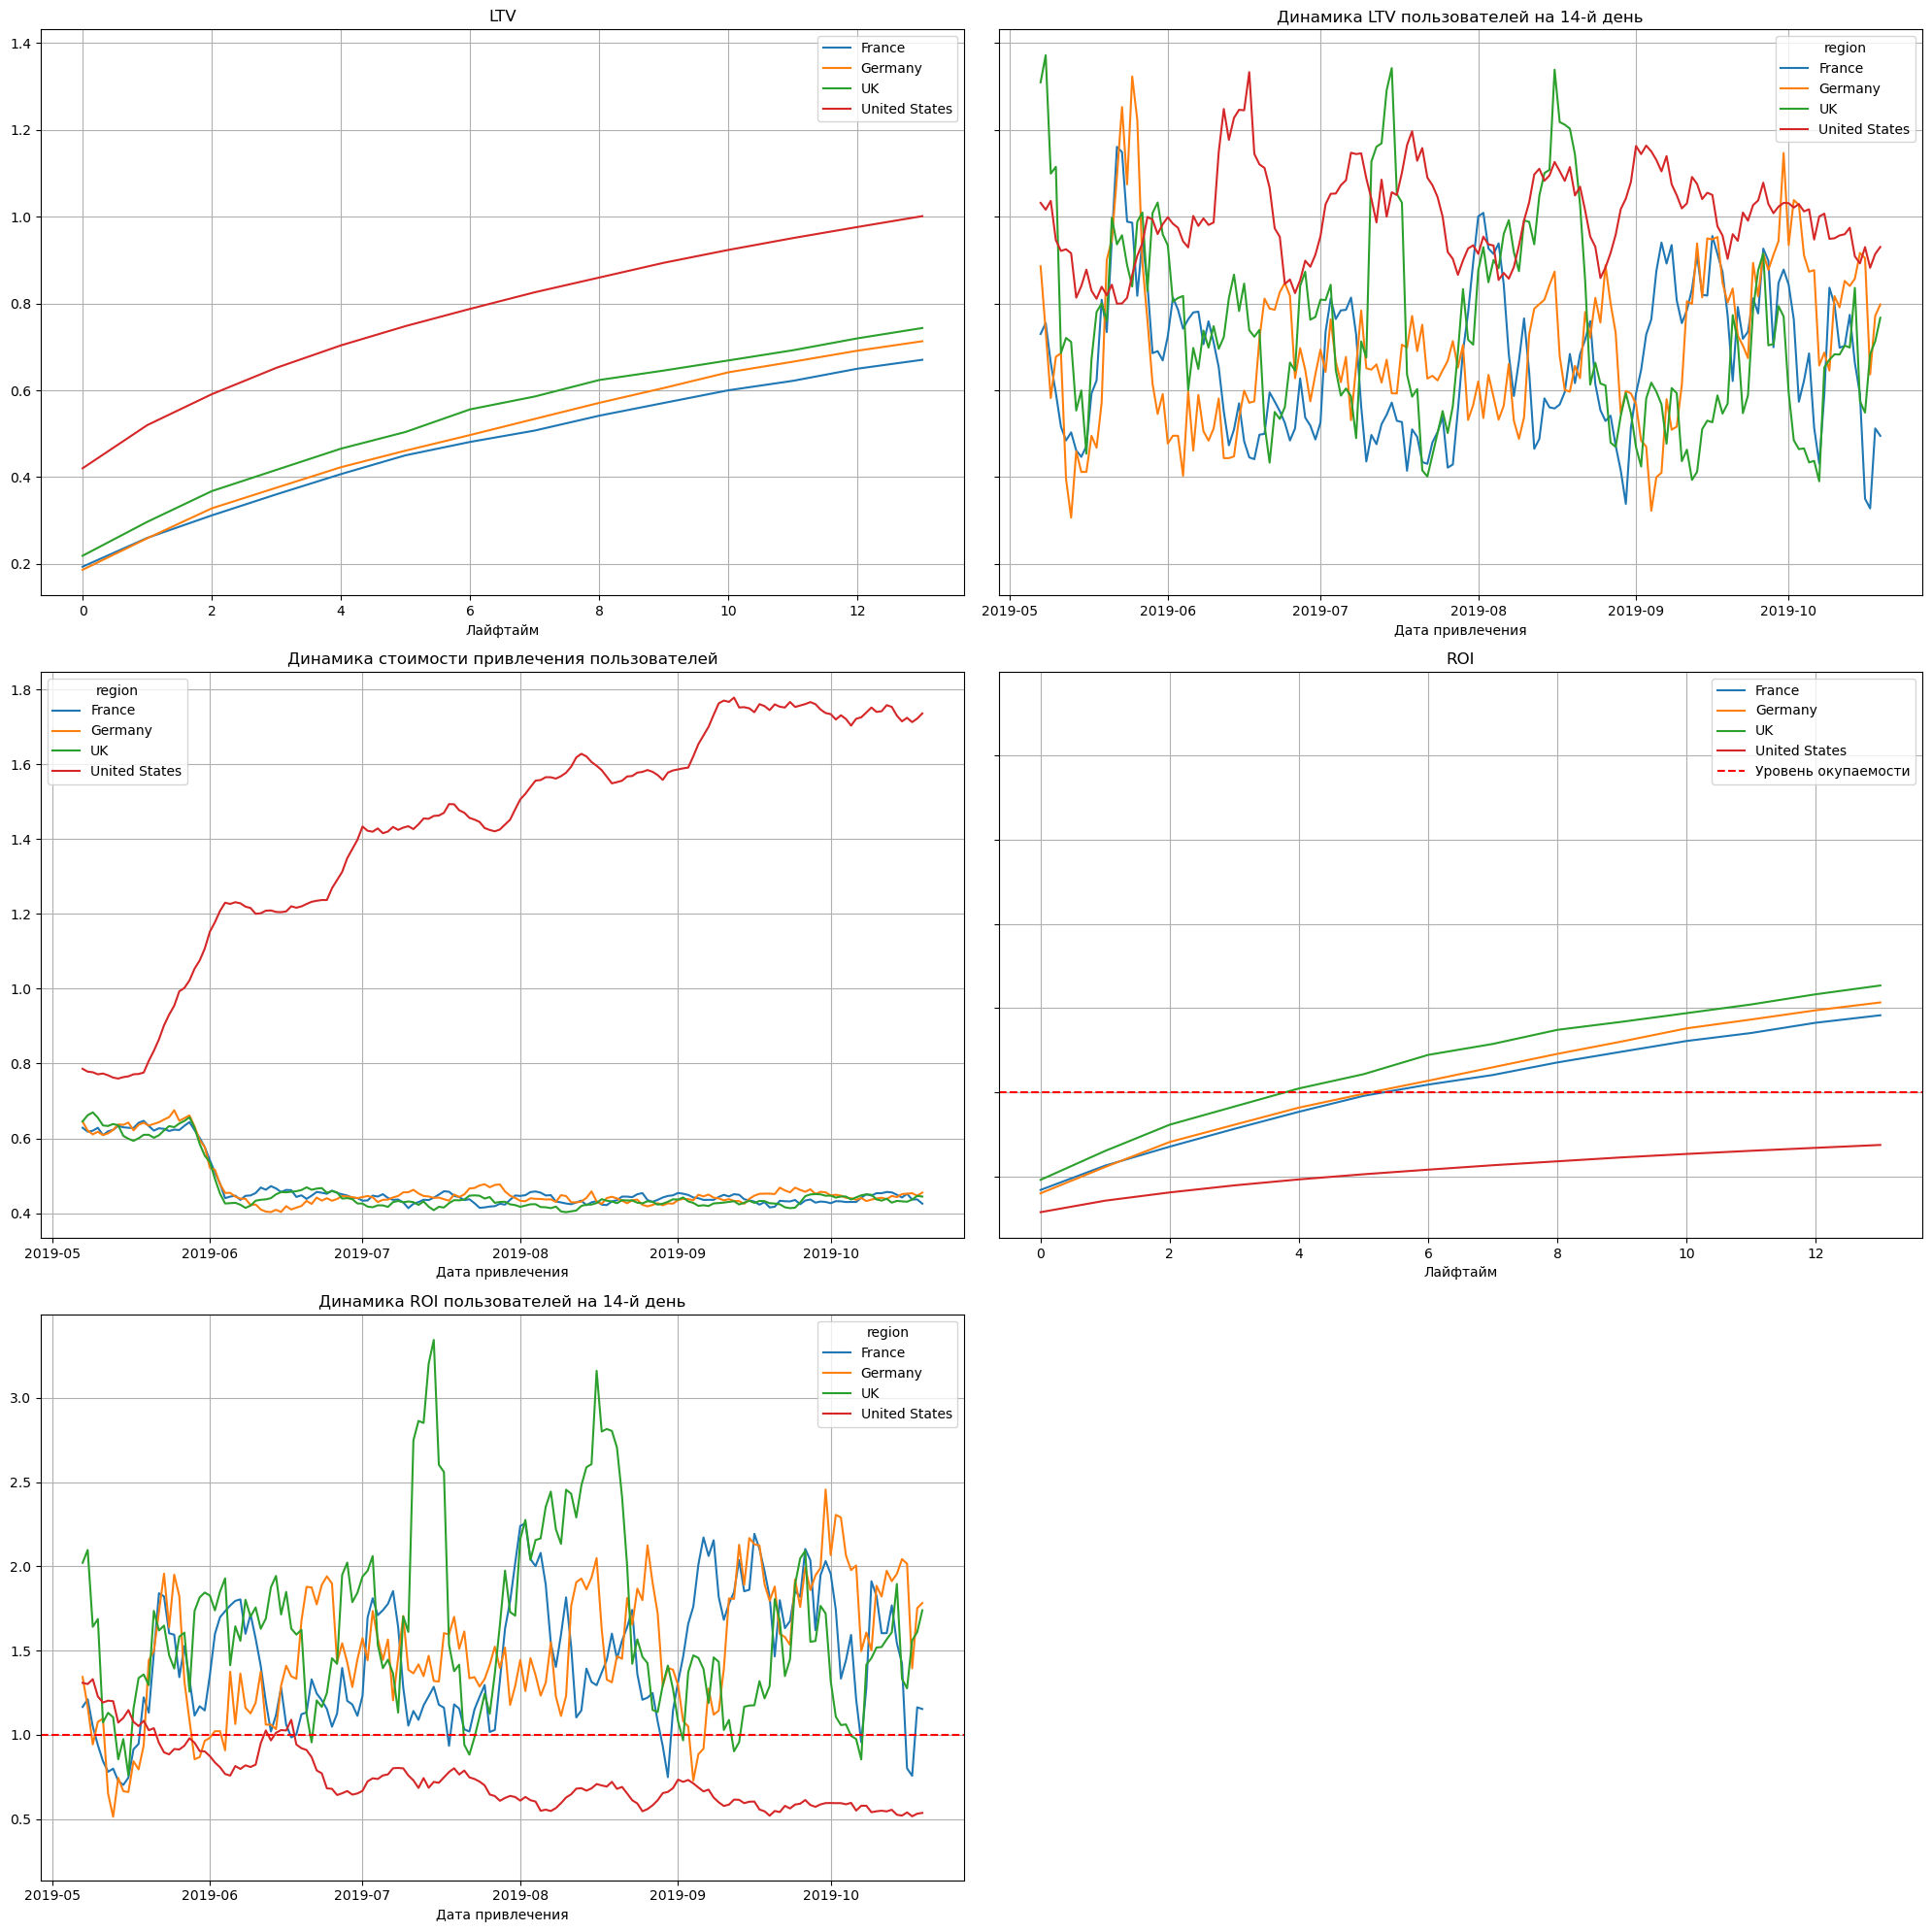

cohort_size       0.0       1.0       2.0       3.0       4.0  \
region                                                                         
France               10516  0.193428  0.259783  0.311696  0.360199  0.406892   
Germany               9030  0.186350  0.258858  0.327945  0.375473  0.422776   
UK                   10536  0.218683  0.296762  0.367626  0.416607  0.465505   
United States        58562  0.420285  0.519636  0.590981  0.651779  0.703511   

                    5.0       6.0       7.0       8.0       9.0      10.0  \
region                                                                      
France         0.450173  0.481019  0.507213  0.541484  0.570906  0.600042   
Germany        0.460907  0.496938  0.534074  0.571104  0.605367  0.641507   
UK             0.503964  0.556090  0.585644  0.623741  0.645527  0.668830   
United States  0.747926  0.787655  0.825852  0.859873  0.893893  0.923530   

                   11.0      12.0      13.0  
region                                       
France         0.621870  0.649871  0.670278  
Germany        0.665932  0.691355  0.713019  
UK             0.692322  0.719800  0.743481  
United States  0.950849  0.976382  1.001316

In [61]:
#Окупаемость рекламы с разбивкой по странам
dimensions = ['region']
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(profiles, orders, observation_date, analysis_horizon, dimensions=dimensions)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)
ltv_grouped

Затраты на пользователей из США самые высокие, при этом США показывают самую низкую окупаемость и удержание.

### Вывод

Причины неэффективности привлечения пользователей:

    1.USA - высокая стоимость привлечения пользователей, низкая окупаемость, плохое удержание. При этом пользователей этой страны больше всего.
    2.TipTop, FaceBoom и AdNonSense - на эти каналы приходятся самые большие расходы, при этом плохое удержание(особенно FaceBoom и AdNonSense) и низкая окупаемость.
    3.Огромные расходы на привлечение пользователей из страны США и канала TipTop.       

Рекомендации для отдела маркетинга:

    1. Распределить средства по каналам более равномерно, например понизить TipTop в пользу YRabbit.
    2. Постараться больше интегрироваться в европейский рынок, привлечение пользователей из стран европы дешевле на дистанции, так же пользователи европейских стран более лояльны.
    3. В случае если пункт 2 не выполним, то пересмотреть отношения к рекламе в USA(понизить расходы, поразмышлять над причинами по которым такое плохое удержание и тд.).